<a href="https://colab.research.google.com/github/amckenna41/csc4009-FIP-ML/blob/main/csc4009.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#mount google drive so it is accessible in notebook - you can skip this and just download the dataset to local Colab folder
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


##**Introduction:**
The objective of this notebook is to explore and analyse the census-income dataset for any bias and or unfairness. This dataset is very popular in the ML community, being manipulated and implemented in a plethora of use-cases. One of the most popular use-cases for the dataset is in the classification task of classifying whether an individual will earn >50k per annum and it is this task that will be explored in the notebook. A range of classifiers are explored and tuned in order to find the optimal algorithm and its associated parameters for the task at hand. The dataset is made up of an arrangement of sensitive/protected attributes that may have an effect on the final classification, be it a positive or negative classification. In the notebook we will explore more the negative implications of the classification results and aim to quantify the bias and unfairness that may arise from the data.

## **Part 1: Loading and pre-processing dataset**
In this section, the required training and test datasets are acquired and loaded from the machine learning repository website. Pre-processing is an essential pre-cursor in any ML task and is carried out to remove any missing or NA values, enode the target variable as categorical, clean some of the attributes to reduce their data verbosity including combining columns into 1 or reducing the number of categorical values of an attribute. 

In [3]:
#install any dependancies
!pip install requests
!pip install catboost
!pip install sklego

     |████████████████████████████████| 65.8MB 61kB/s 
     |████████████████████████████████| 215kB 12.3MB/s 


In [4]:
#import dependancies
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import time
import warnings
import random
random.seed(100)
warnings.filterwarnings('ignore')

In [5]:
!ls "/content/drive/My Drive"

'2050 Dystopian Corona.gdoc'	 keras-tuner-multi-output-cnn.ipynb
 adult.csv			 model_architecture.json
 adult_data.csv			 model_output.csv
 adult_name.csv			 ppi
 adult_test.csv			 PPIData
 ai_bias.ipynb			 ppi_ebola.ipynb
'Colab Notebooks'		 protein_activity.ipynb
'CSC4009 - FIP-ML.gdoc'		 protein_activity_lazypredict.ipynb
 csc4009.ipynb			 protein_activity_ML.ipynb
'CSC4009 - practical1.gslides'	 protein_interact_hiv.ipynb
 deepdream			 psp
 dna_in60.gdoc			 rna_in60.gdoc
 dna_transcription_in60.gdoc	 stringdb.ipynb
 glasses_img_amazon		 Untitled0.ipynb


In [6]:
dataset_name = "adult_data.csv"
test_name = "adult_test.csv"
names_name = "adult_name.csv"
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
names_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
dir_path = "/content/drive/My Drive/"

#download train and test data and store in Google Drive
def download_data():
    if not os.path.isfile(os.path.join("/content/drive/My Drive","adult_data.csv")):

          try:
          #get data from url
            r = requests.get(data_url, allow_redirects = True) #error handling, if response == 200
            r.raise_for_status()    #if response status code != 200

            source_path = (os.path.join(dir_path, dataset_name))

            #open local file
            open(source_path, 'wb').write(r.content)
          except OSError:
                raise OSError('Error downloading dataset\n')

    if not os.path.isfile(os.path.join("/content/drive/My Drive","adult_test.csv")):

          try:
          #get data from url
            r = requests.get(test_url, allow_redirects = True) #error handling, if response == 200
            r.raise_for_status()    #if response status code != 200

            source_path = (os.path.join(dir_path, test_name))

            #open local file
            open(source_path, 'wb').write(r.content)
          except OSError:
             raise OSError('Error downloading dataset\n')

    if not os.path.isfile(os.path.join("/content/drive/My Drive","adult_names.csv")):

        try:
        #get data from url
          r = requests.get(names_url, allow_redirects = True) #error handling, if response == 200
          r.raise_for_status()    #if response status code != 200

          source_path = (os.path.join(dir_path, names_name))

          #open local file
          open(source_path, 'wb').write(r.content)
        except OSError:
            raise OSError('Error downloading dataset\n')



#download train and test data and store locally, if drive not mounted
def download_data_unmounted():

      try:
      #get data from url
        r = requests.get(data_url, allow_redirects = True) #error handling, if response == 200
        r.raise_for_status()    #if response status code != 200

        #open local file
        open(dataset_name, 'wb').write(r.content)
      except OSError:
            print('Error downloading dataset\n')

      try:
      #get data from url
        r = requests.get(test_url, allow_redirects = True) #error handling, if response == 200
        r.raise_for_status()    #if response status code != 200

        #open local file
        open(test_name, 'wb').write(r.content)
      except OSError:
          print('Error downloading dataset\n')

      try:
      #get data from url
        r = requests.get(names_url, allow_redirects = True) #error handling, if response == 200
        r.raise_for_status()    #if response status code != 200

        #open local file
        open(names_name, 'wb').write(r.content)
      except OSError:
          print('Error downloading dataset\n')

In [7]:
#try downloading data to google drive if it is mounted, if not then just download datasets locally
try:
  download_data()
except:
  download_data_unmounted()

In [8]:
#copy data from Google drive to cwd

!cp "/content/drive/My Drive/adult_data.csv" "adult_train"
!cp "/content/drive/My Drive/adult_test.csv" "adult_test"
!cp "/content/drive/My Drive/adult.csv" "adult"
!cp "adult_data.csv" "adult_train"
!cp "adult_test.csv" "adult_test"

cp: cannot stat 'adult_data.csv': No such file or directory
cp: cannot stat 'adult_test.csv': No such file or directory


In [9]:
!ls

adult  adult_test  adult_train	drive  sample_data


In [10]:
#import dataset as pandas DataFrame, setting any NA values to '?'
columns = ["age", "workClass", "fnlwgt", "education", "education-num","marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
          
train_adult = pd.read_csv("adult_train", names=columns, sep=' *, *', na_values='?')
test_adult = pd.read_csv("adult_test", names=columns, sep=' *, *', skiprows=1,na_values='?')

In [11]:
test_adult.head()
# test_adult.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.


In [12]:
#get dataset shape 
print('Train Shape: ', train_adult.shape)
print('Test Shape: ', test_adult.shape)

Train Shape:  (32561, 15)
Test Shape:  (16281, 15)


In [13]:
#get dataset info 
train_adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workClass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [14]:
#replacing any missing values with the mode (most common value) of the column 
train_adult['occupation'] = train_adult['occupation'].fillna('Prof-specialty')
train_adult['workClass'] = train_adult['workClass'].fillna('Private')
train_adult['native-country'] = train_adult['native-country'].fillna('United-States')

#replacing any missing values with the mode (most common value) of the column 
test_adult['occupation'] = test_adult['occupation'].fillna('Prof-specialty')
test_adult['workClass'] = test_adult['workClass'].fillna('Private')
test_adult['native-country'] = test_adult['native-country'].fillna('United-States')


In [15]:
train_adult.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [16]:
test_adult['income']

0        <=50K.
1        <=50K.
2         >50K.
3         >50K.
4        <=50K.
          ...  
16276    <=50K.
16277    <=50K.
16278    <=50K.
16279    <=50K.
16280     >50K.
Name: income, Length: 16281, dtype: object

In [17]:
train_adult['income']

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
32556    <=50K
32557     >50K
32558    <=50K
32559    <=50K
32560     >50K
Name: income, Length: 32561, dtype: object

In [18]:
#transforming income target variable into categorical binary form where 0 is <=50k, 1 is >50k 
train_adult['income']=train_adult['income'].map({'<=50K': 0, '>50K': 1})
test_adult['income']=test_adult['income'].map({'<=50K.': 0, '>50K.': 1}) #for test data, ensure there is '.' at end of row entries, '<=50k.' not <=50k'


In [19]:
#Creating Capital difference column which is gain - loss 
train_adult['capital-diff'] = train_adult['capital-gain'] - train_adult['capital-loss']
train_adult.drop(['capital-loss'], axis = 1, inplace = True)
train_adult.drop(['capital-gain'], axis = 1, inplace = True)

#Creating Capital difference column which is gain - loss 
test_adult['capital-diff'] = test_adult['capital-gain'] - test_adult['capital-loss']
test_adult.drop(['capital-loss'], axis = 1, inplace = True)
test_adult.drop(['capital-gain'], axis = 1, inplace = True)

In [20]:
#dropping education number column as it is just a numerical representation of the education column
train_adult.drop(['education-num'], axis = 1, inplace = True)

#updating education column to combine several categories into one, removing verbose categories 
train_adult['education'].replace(['5th-6th', '1st-4th', 'Preschool'],
                             'Primary School', inplace = True)

train_adult['education'].replace(['7th-8th', '9th','10th','11th','12th'],
                             'Secondary School', inplace = True)

test_adult.drop(['education-num'], axis = 1, inplace = True)
test_adult['education'].replace(['5th-6th', '1st-4th', 'Preschool'],
                             'Primary School', inplace = True)

test_adult['education'].replace(['7th-8th', '9th','10th','11th','12th'],
                             'Secondary School', inplace = True)

train_adult['education'].value_counts()

HS-grad             10501
Some-college         7291
Bachelors            5355
Secondary School     3701
Masters              1723
Assoc-voc            1382
Assoc-acdm           1067
Prof-school           576
Primary School        552
Doctorate             413
Name: education, dtype: int64

In [21]:
#splitting age into 9 bins of 10 years each (except for 17-20 bin) categories of 
train_adult['age'] = pd.cut(train_adult['age'], bins = [17, 20, 31, 40, 51, 60, 71, 80, 91, 100], labels = ['17-20', '21-30', '31-40','41-50','51-60','61-70','71-80','81-90','91-100'])
test_adult['age'] = pd.cut(test_adult['age'], bins = [17, 20, 31, 40, 51, 60, 71, 80, 91, 100], labels = ['17-20', '21-30', '31-40','41-50','51-60','61-70','71-80','81-90','91-100'])

In [22]:
#Split hours-per-week column into various bins to reduce 1-100 hour spread 
train_adult['hours-per-week'] = pd.cut(train_adult['hours-per-week'], 
                                   bins = [0, 30, 45, 100], 
                                   labels = ['Lesser Working Week', 'Normal Working Week', 'Extra Working Week'])
test_adult['hours-per-week'] = pd.cut(test_adult['hours-per-week'], 
                                   bins = [0, 30, 45, 100], 
                                   labels = ['Lesser Working Week', 'Normal Working Week', 'Extra Working Week'])


In [23]:
#as can be seen from the above plot, the data is largely skewed by the amount of 'United-States' entries for the native-country column,
#seperating the attribute into 'United-States' and 'Other' should account for this and skew the data less 

count = train_adult['native-country'].value_counts()
countries = np.array(train_adult['native-country'].unique())
countries = np.delete(countries, 0)

train_adult['native-country'].replace(countries, 'Other', inplace = True)

count = test_adult['native-country'].value_counts()
countries = np.array(test_adult['native-country'].unique())
countries = np.delete(countries, 0)

test_adult['native-country'].replace(countries, 'Other', inplace = True)

In [24]:
train_adult.head()

,age,workClass,fnlwgt,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,capital-diff
0,31-40,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,Normal Working Week,United-States,0,2174
1,41-50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,Lesser Working Week,United-States,0,0
2,31-40,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,Normal Working Week,United-States,0,0
3,51-60,Private,234721,Secondary School,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,Normal Working Week,United-States,0,0
4,21-30,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Normal Working Week,Other,0,0


In [25]:
test_adult.head()

,age,workClass,fnlwgt,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,capital-diff
0,21-30,Private,226802,Secondary School,Never-married,Machine-op-inspct,Own-child,Black,Male,Normal Working Week,United-States,0,0
1,31-40,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,Extra Working Week,United-States,0,0
2,21-30,Local-gov,336951,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,Normal Working Week,United-States,1,0
3,41-50,Private,160323,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,Normal Working Week,United-States,1,7688
4,17-20,Private,103497,Some-college,Never-married,Prof-specialty,Own-child,White,Female,Lesser Working Week,United-States,0,0


## **Part 2: Exploratory Analysis of dataset**
In this section we explore the different attributes and their makeup and distribution within the dataset through a variety of visualisations. This process will assist in identifying any visible patterns in the dataset there may be, assisting in the classifcation and bias evaluation process. Firstly, income will be compared against any of the non-sensitive/non-protected attributes, followed by the analysis of protected attributes.

In [26]:
#Plots for age, captial difference, education number and hours per week distribution in dataset as well as their mean
# xaxes = ['age','capital difference','hours per week']
# yaxes = 'Frequency'
# titles = ['Age Distribution','Capital Difference Distribution','Hours per week Distribution'] 
# cols = ['age','capital-diff','hours-per-week']

# f,a = plt.subplots(3, figsize=(12,6))
# a = a.ravel()
# for idx,ax in enumerate(a):
#     ax.hist(train_adult[cols[idx]])   #possible error when executing but that's ok 
#     ax.set_title(titles[idx])
#     ax.set_xlabel(xaxes[idx])
#     ax.set_ylabel(yaxes[idx])
#     ax.axvline(train_adult[cols[idx]].mean(),color='peru', linestyle='dashed',linewidth=3)
# plt.tight_layout()

Text(0.5, 1.0, 'Education per sex')

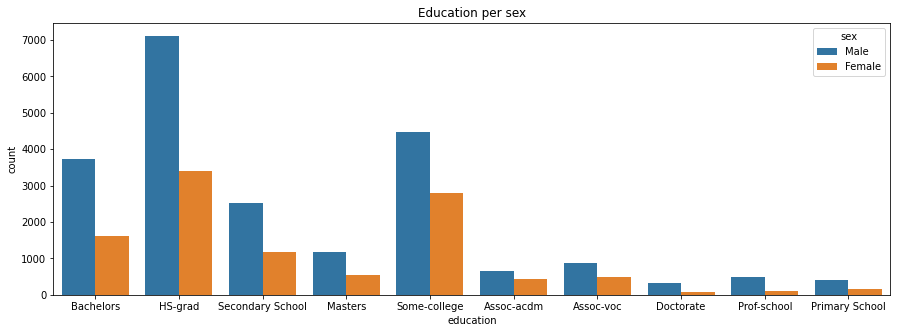

In [27]:
#education per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'education', hue = 'sex', data = train_adult)
plt.title('Education per sex')

Text(0.5, 1.0, 'Workclass per sex')

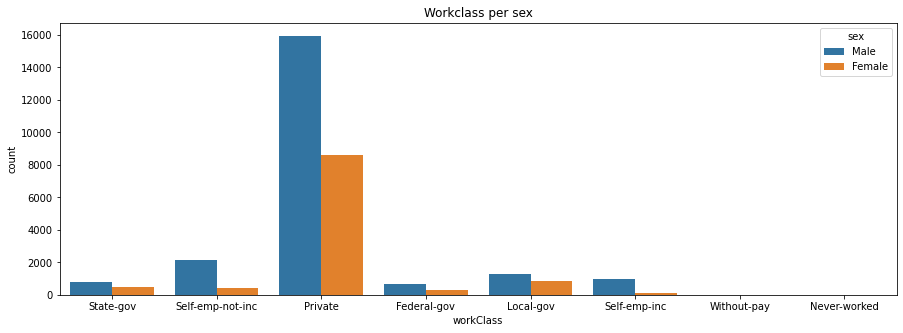

In [28]:
#workClass per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'workClass', hue = 'sex', data = train_adult)
plt.title('Workclass per sex')

Text(0.5, 1.0, 'Occupation per sex')

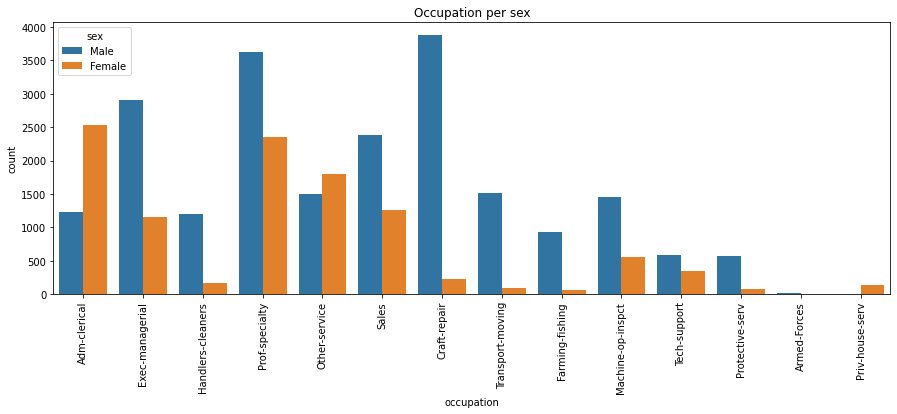

In [29]:
#occupation per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'occupation', hue = 'sex', data = train_adult)
plt.xticks(rotation=90)
plt.title('Occupation per sex')

Text(0.5, 1.0, 'Native-country per sex')

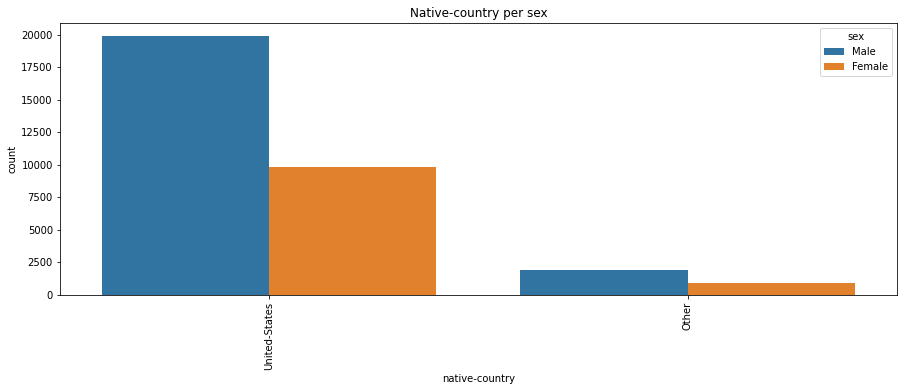

In [30]:
#native-country per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'native-country', hue = 'sex', data = train_adult)
plt.xticks(rotation=90)
plt.title('Native-country per sex')

Text(0.5, 1.0, 'Race per sex')

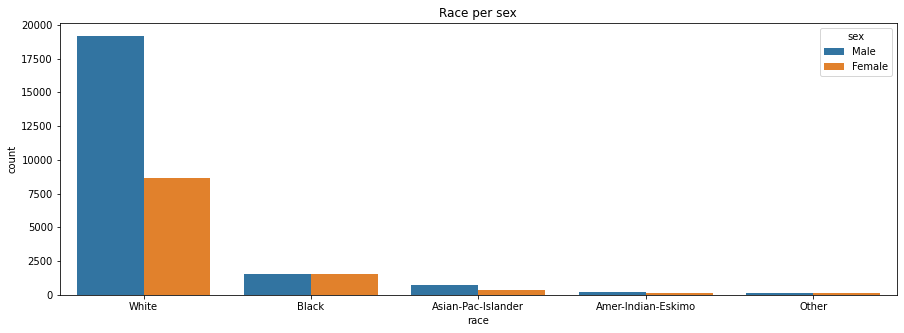

In [31]:
#race per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'race', hue = 'sex', data = train_adult)
plt.title('Race per sex')

Text(0.5, 1.0, 'Relationship per sex')

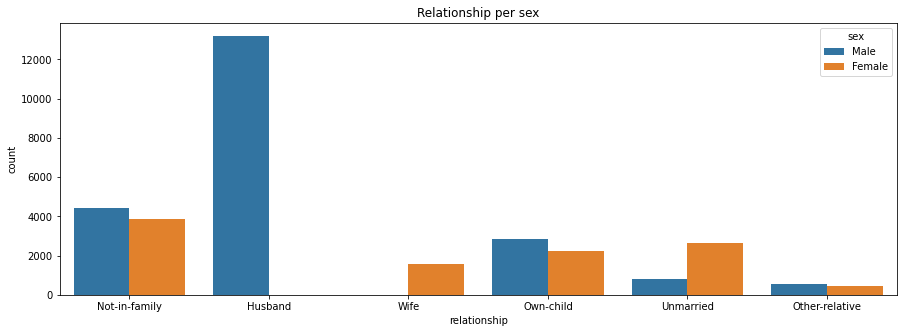

In [32]:
#relationship per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'relationship', hue = 'sex', data = train_adult)
plt.title('Relationship per sex')

Text(0.5, 1.0, 'Marital-status per sex')

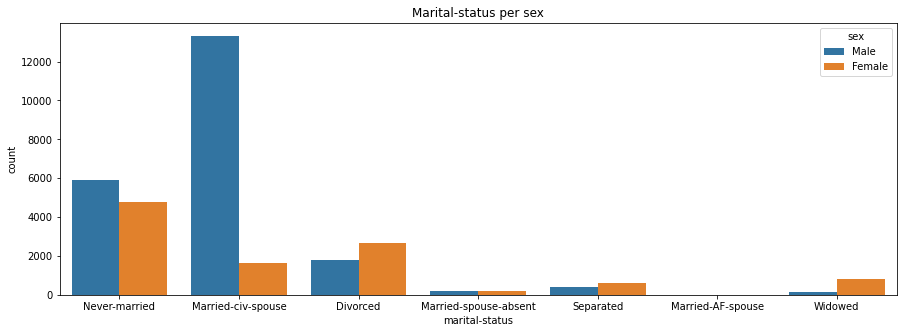

In [33]:
#marital-status per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'marital-status', hue = 'sex', data = train_adult)
plt.title('Marital-status per sex')

Text(0.5, 1.0, 'Marital-status per sex')

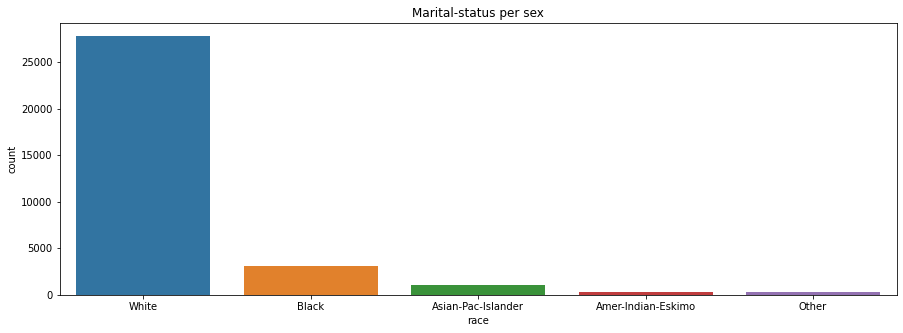

In [34]:
plt.figure(figsize=(15, 5))
sns.countplot(x = 'race',  data = train_adult)
plt.title('Marital-status per sex')

In [35]:
test_adult['relationship'].value_counts()

Husband           6523
Not-in-family     4278
Own-child         2513
Unmarried         1679
Wife               763
Other-relative     525
Name: relationship, dtype: int64

Text(0.5, 1.0, 'Income Frequency')

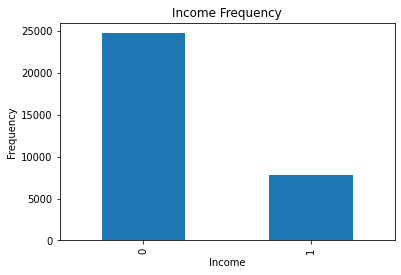

In [36]:
#visualising income 
train_adult['income'].value_counts().plot(kind='bar')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Frequency')

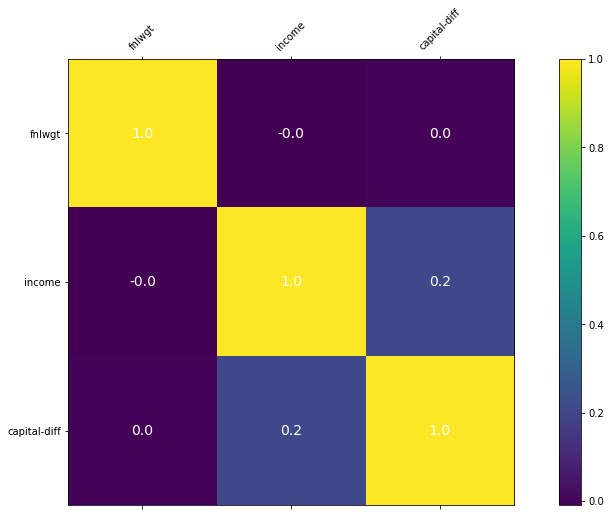

In [37]:
#get correlation between all discrete and continuous attributes 
plt.figure(figsize=(16,8))
plt.matshow(train_adult.corr(), fignum=1)
# plt.matshow(train_adult.corr())
plt.colorbar()
plt.xticks(np.arange(len(train_adult.corr().columns)), train_adult.corr().columns.values, rotation = 45) 
plt.yticks(np.arange(len(train_adult.corr().columns)), train_adult.corr().columns.values) 
for (i, j), corr in np.ndenumerate(train_adult.corr()):
    plt.text(j, i, '{:0.1f}'.format(corr), ha='center', va='center', color='white', fontsize=14)


The above correlation visualisation showcases each of the attributes and their relationships with one another. Each non-categorical attribute is compared with each other, calculating their correlation coefficent. A positive value indicates the two variables move in the same direction and may be related, a negative value indicates the opposite. From the visualisation we can note that the attribute 'fnlwgt' has a correlation of 0 or -0.1 for each variable, thus indicating that it has no relationship with any other variables - this means we can drop this attribute altogether. For the desired attribute, income, one can note the positive correlation it has with the remainder of the attributes, having the strongest correlation with the education-num variable. In later sections we will dive more into these relationships and correlations within the dataset.

In [38]:
#fnlwgt attribute has no correlation with any other attributes, drop from dataset
train_adult.drop(['fnlwgt'], axis = 1, inplace = True)
test_adult.drop(['fnlwgt'], axis = 1, inplace = True)


In [39]:
train_adult.head()

,age,workClass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,capital-diff
0,31-40,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,Normal Working Week,United-States,0,2174
1,41-50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,Lesser Working Week,United-States,0,0
2,31-40,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,Normal Working Week,United-States,0,0
3,51-60,Private,Secondary School,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,Normal Working Week,United-States,0,0
4,21-30,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Normal Working Week,Other,0,0


Text(0.5, 1.0, 'Age per Sex')

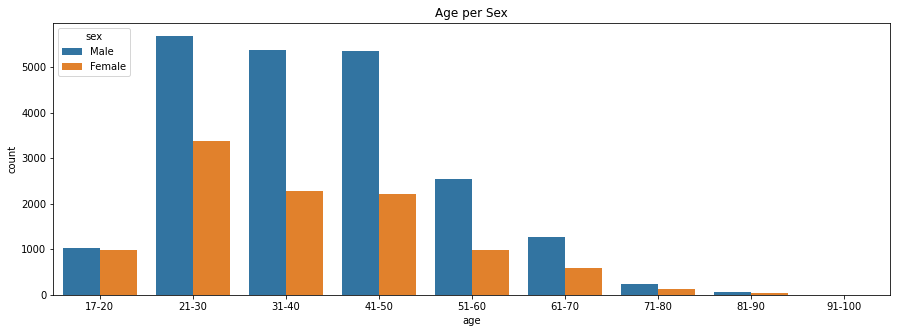

In [40]:
#age per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'age', hue = 'sex', data = train_adult)
plt.title('Age per Sex')


Text(0.5, 1.0, 'Hours-per-week per Sex')

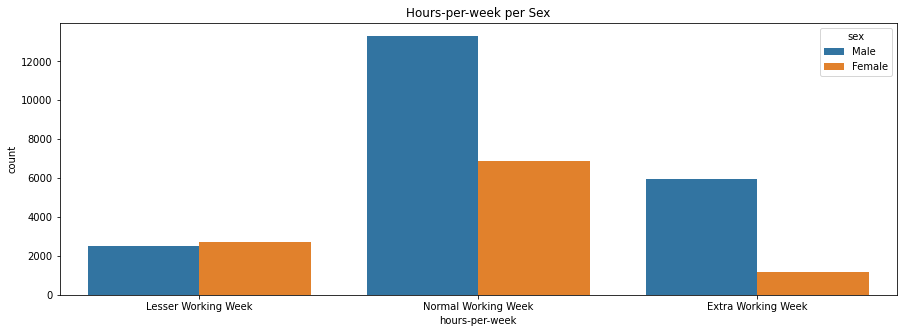

In [41]:
#hours-per-week per sex in data
plt.figure(figsize=(15, 5))
sns.countplot(x = 'hours-per-week', hue = 'sex', data = train_adult)
plt.title('Hours-per-week per Sex')


Text(0.5, 1.0, 'Type of working week per age group')

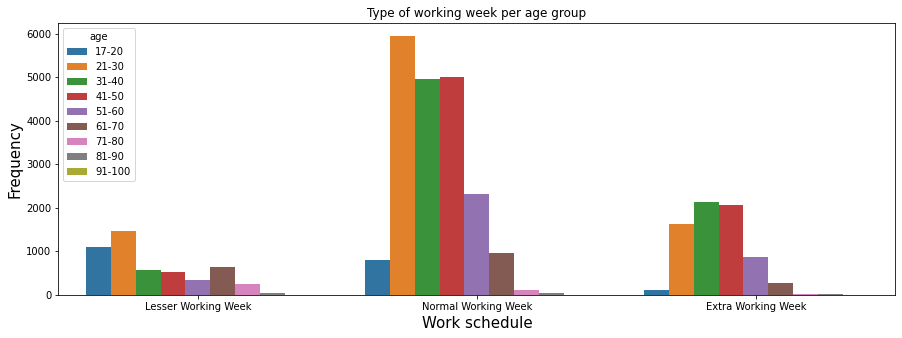

In [42]:
#Visualising working week vs age
plt.figure(figsize=(15, 5))
sns.countplot(x = 'hours-per-week', hue = 'age', data = train_adult)
plt.xlabel('Work schedule', fontsize =15)
plt.ylabel('Frequency', fontsize =15)
plt.title('Type of working week per age group')

**Analysing Income vs other non-sensitive attributes:**





(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

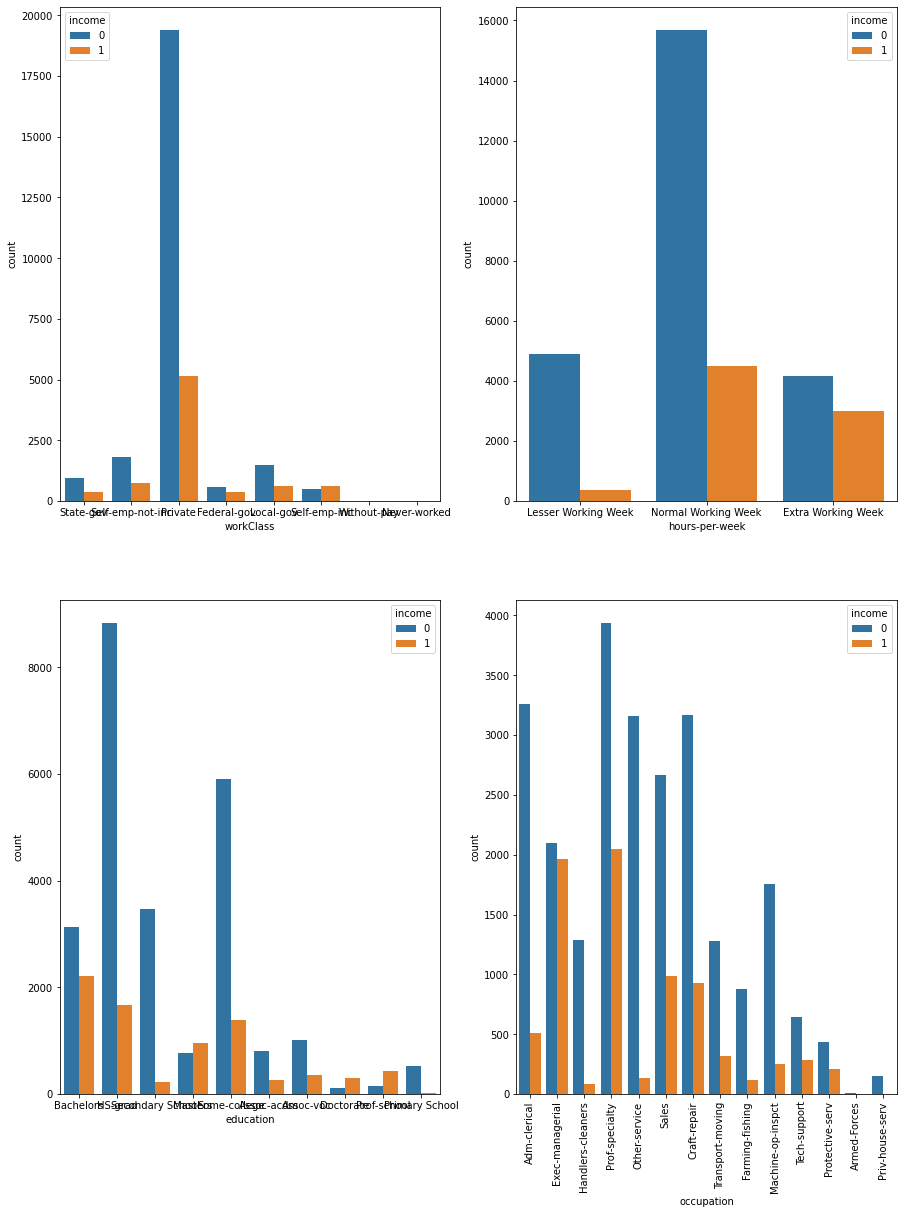

In [43]:
# dataset=train_adult.copy()
train_adult.head()

fig, ((a,b),(c,d)) = plt.subplots(2,2,figsize=(15,20))
sns.countplot(train_adult['workClass'],hue=train_adult['income'],ax=a)
plt.xticks(rotation=90)
sns.countplot(train_adult['hours-per-week'],hue=train_adult['income'],ax=b)
plt.xticks(rotation=90)
sns.countplot(train_adult['education'],hue=train_adult['income'],ax=c)
sns.countplot(train_adult['occupation'],hue=train_adult['income'],ax=d)
plt.xticks(rotation=90)


**Analysing Sensitive Attributes:** 
In the previous section, the dataset and its constiuent attributes were explored through summary statistics and visualisations. Through these visualisations it became apparent that many of the attributes are unequal and unfairly distributed in some cases. Some of this can be attributed to the general makeup of the dataset and the uneven distribution of some of the attributes but one may also conclude that there exists an element of individual or group unfairness. In this section I wil be analysing some of the more sensitive attributes in the adult dataset. These will include race, gender, marital status, age, native country and relatioship. The attributes will be compared against the target income variable, which should help in visualising and identifying any biases or unfairness that may be present as to whether an individual may have an income of >50,000.


In [44]:
# fig, ((a,b),(c,d)) = plt.subplots(2,2,figsize=(15,20))
# sns.countplot(train_adult['workClass'],hue=train_adult['income'],ax=a)
# plt.xticks(rotation=90)
# sns.countplot(train_adult['hours-per-week'],hue=train_adult['income'],ax=b)
# plt.xticks(rotation=90)
# sns.countplot(train_adult['education'],hue=train_adult['income'],ax=c)
# sns.countplot(train_adult['occupation'],hue=train_adult['income'],ax=d)
# plt.xticks(rotation=90)

Text(0.5, 1.0, 'Race vs Income')

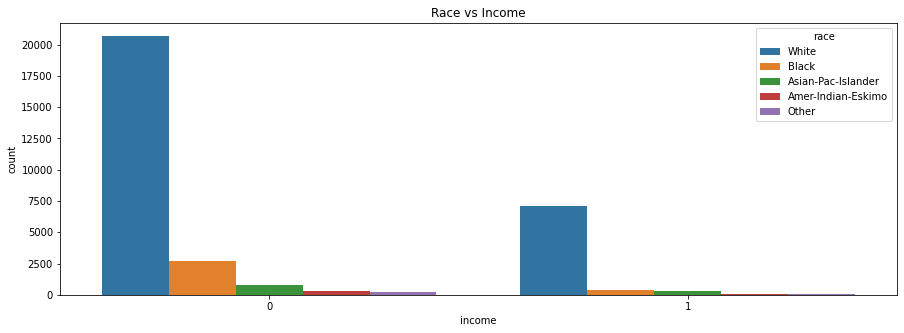

In [45]:
#Visualising income vs race
plt.figure(figsize=(15, 5))
sns.countplot(x = 'income', hue = 'race', data = train_adult)
plt.title('Race vs Income')


Text(0.5, 1.0, 'Age vs Income')

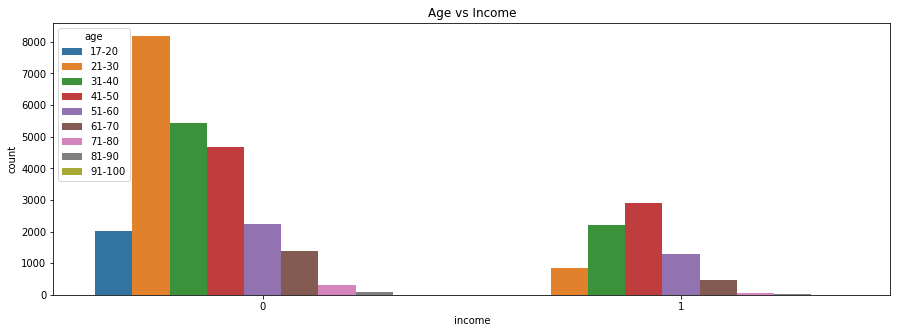

In [46]:
#visualising income vs age 
plt.figure(figsize=(15, 5))
sns.countplot(x = 'income',hue = 'age', data = train_adult)
plt.title('Age vs Income')


Text(0.5, 1.0, 'Sex vs Income')

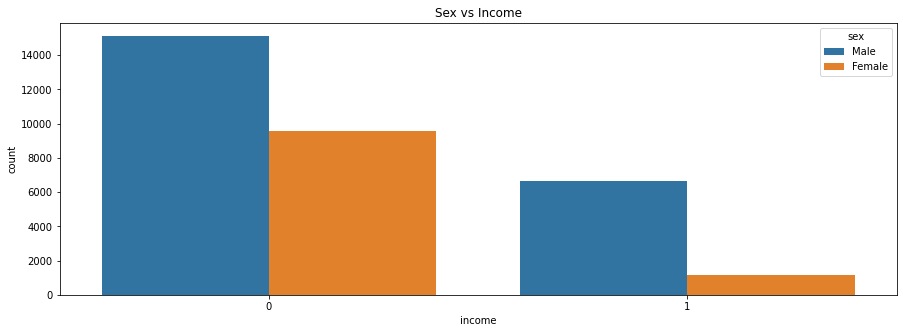

In [47]:
#visualising income vs sex
plt.figure(figsize=(15, 5))
sns.countplot(x = 'income', hue = 'sex', data = train_adult)
plt.title('Sex vs Income')


Text(0.5, 1.0, 'Martial Status vs Income')

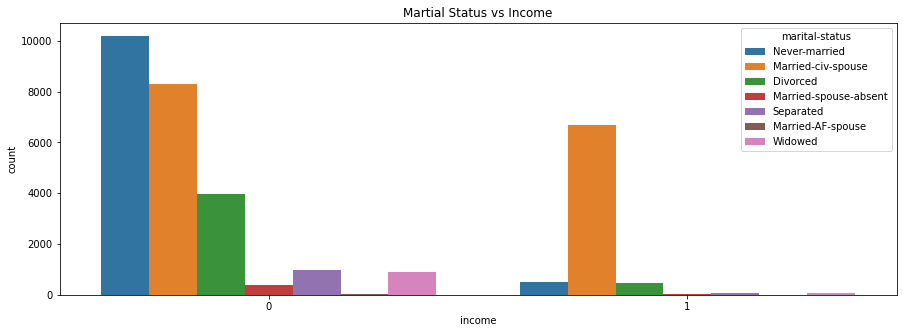

In [48]:
#visualising income vs marital status
plt.figure(figsize=(15, 5))
sns.countplot(x = 'income', hue = 'marital-status', data = train_adult)
plt.title('Martial Status vs Income')


Text(0.5, 1.0, 'Relationship vs Income')

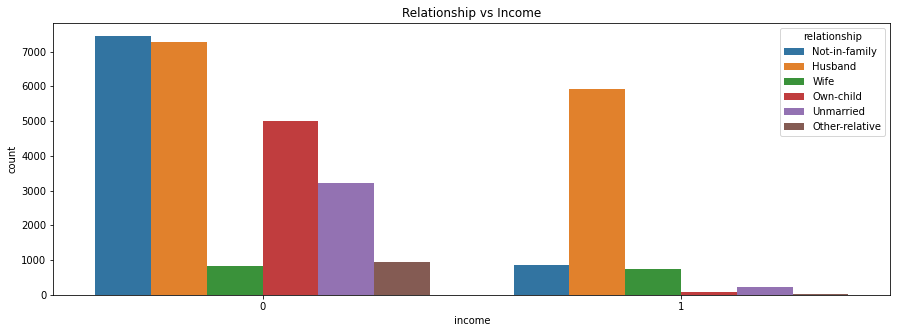

In [49]:
#visualising income vs relationship
plt.figure(figsize=(15, 5))
sns.countplot(x = 'income', hue = 'relationship', data = train_adult)
plt.title('Relationship vs Income')


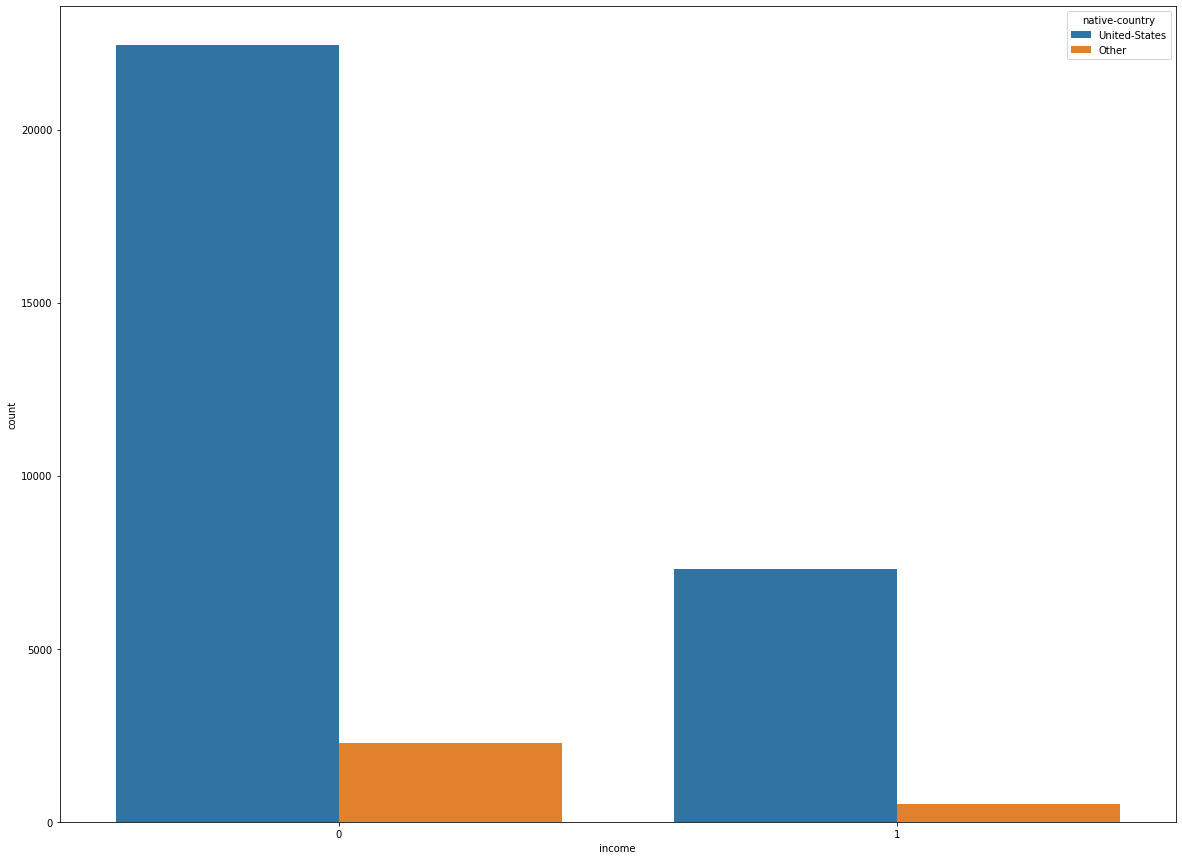

In [50]:
#visualising income vs native-country
plt.figure(figsize=(20, 15))
sns.countplot(x = 'income', hue = 'native-country', data = train_adult)   


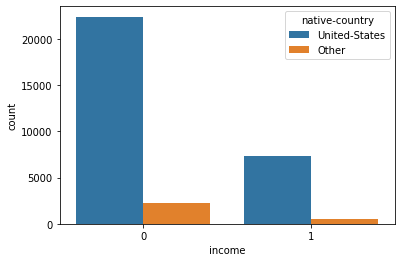

In [51]:
#visualising native-country vs income after transforming column
sns.countplot(x = 'income', hue = 'native-country', data = train_adult)  


In [52]:
train_adult.head()

,age,workClass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,capital-diff
0,31-40,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,Normal Working Week,United-States,0,2174
1,41-50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,Lesser Working Week,United-States,0,0
2,31-40,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,Normal Working Week,United-States,0,0
3,51-60,Private,Secondary School,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,Normal Working Week,United-States,0,0
4,21-30,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Normal Working Week,Other,0,0


## **Part 3: Building a classifer**
The aim of this section is to determine the most appropriate and accurate classification algorithm for the task of classifying if an individual will earn >50,000 per annum. All of the training features discussed thus far wil be used for training, with the income attribute being the target variable. A selection of classification algorithms are implemented and evaluated as well as a vigourous process of hyperparameter tuning to find the optimal set of hyperparameters for each classifier. The algorithms explored include: Random Forest, Decision Trees, Bagged Decision Trees, Logistic Regression, KNN, SVM, Stochastic Gradient Boosting, GausianNB and Convolutional Neural Networks. All hyperparameter tuning code has been commented out.

###**Part 3.1: Splitting, encoding and scaling dataset**

In [108]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from catboost import CatBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


In [109]:
#make copy of original training and test datasets 
train_data = train_adult.copy()
test_data = test_adult.copy()

train_test = train_adult.copy()

In [110]:
test_data

,age,workClass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,capital-diff
0,21-30,Private,Secondary School,Never-married,Machine-op-inspct,Own-child,Black,Male,Normal Working Week,United-States,0,0
1,31-40,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,Extra Working Week,United-States,0,0
2,21-30,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,Normal Working Week,United-States,1,0
3,41-50,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,Normal Working Week,United-States,1,7688
4,17-20,Private,Some-college,Never-married,Prof-specialty,Own-child,White,Female,Lesser Working Week,United-States,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
16276,31-40,Private,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,Normal Working Week,United-States,0,0
16277,61-70,Private,HS-grad,Widowed,Prof-specialty,Other-relative,Black,Male,Normal Working Week,United-States,0,0
16278,31-40,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,Extra Working Week,United-States,0,0
16279,41-50,Private,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,Normal Working Week,United-States,0,5455


In [111]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             16081 non-null  category
 1   workClass       16281 non-null  object  
 2   education       16281 non-null  object  
 3   marital-status  16281 non-null  object  
 4   occupation      16281 non-null  object  
 5   relationship    16281 non-null  object  
 6   race            16281 non-null  object  
 7   sex             16281 non-null  object  
 8   hours-per-week  16281 non-null  category
 9   native-country  16281 non-null  object  
 10  income          16281 non-null  int64   
 11  capital-diff    16281 non-null  int64   
dtypes: category(2), int64(2), object(8)
memory usage: 1.3+ MB


In [112]:
# #encoding any object or category column dtypes as integers 
le = preprocessing.LabelEncoder()
train_data = train_data.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')
test_data = test_data.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')


In [113]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             16281 non-null  int64
 1   workClass       16281 non-null  int64
 2   education       16281 non-null  int64
 3   marital-status  16281 non-null  int64
 4   occupation      16281 non-null  int64
 5   relationship    16281 non-null  int64
 6   race            16281 non-null  int64
 7   sex             16281 non-null  int64
 8   hours-per-week  16281 non-null  int64
 9   native-country  16281 non-null  int64
 10  income          16281 non-null  int64
 11  capital-diff    16281 non-null  int64
dtypes: int64(12)
memory usage: 1.5 MB


In [114]:
#splitting data into features and target 
X = train_data.drop(['income'], axis = 1)
Y = train_data['income']

In [115]:
X.head()  
##from sklearn.utils import shuffle
# df_adult = shuffle(df_adult)

,age,workClass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital-diff
0,2,6,2,4,0,1,4,1,2,1,124
1,3,5,2,2,3,0,4,1,1,1,91
2,2,3,4,0,5,1,4,1,2,1,91
3,4,3,8,2,5,0,2,1,2,1,91
4,1,3,2,2,9,5,2,0,2,0,91


In [116]:
Y

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: income, Length: 32561, dtype: int64

**Possibly sclaing and encoding and scaling multiple times????**

In [117]:
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)
#y_cv = cross_val_predict(pls, X, y, cv=5) #cv = 10 
X_train = X 
Y_train = Y
X_test = test_data.drop(['income'],axis =1 )
Y_test = test_data['income']

In [118]:
Y_test.value_counts()

0    12435
1     3846
Name: income, dtype: int64

In [119]:
# #encode categorical variables in such that they contain only values between 0 and n_classes-1 and can then be used within the classifiers
# categorical = ['age','workClass','education', 'marital-status', 'occupation', 'relationship','race', 'sex','native-country']

# for feature in categorical:
#         le = preprocessing.LabelEncoder()
#         print(feature)
#         X_train[feature] = le.fit_transform(X_train[feature])
#         X_test[feature] = le.transform(X_test[feature])

In [120]:
#Standardize features in training and test sets by removing the mean and scaling to unit variance

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

#df = df.astype({"Name":'category', "Age":'int64'}) 






In [121]:
X_train.head()


,age,workClass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital-diff
0,-0.234004,2.624298,-1.098810,0.921634,-1.545256,-0.277805,0.393668,0.703071,0.727859,0.307208,1.157523
1,0.428725,1.721100,-1.098810,-0.406212,-0.790092,-0.900181,0.393668,0.703071,-0.486084,0.307208,-0.126989
2,-0.234004,-0.085296,-0.393115,-1.734058,-0.286649,-0.277805,0.393668,0.703071,0.727859,0.307208,-0.126989
3,1.091454,-0.085296,1.018273,-0.406212,-0.286649,-0.900181,-1.962621,0.703071,0.727859,0.307208,-0.126989
4,-0.896732,-0.085296,-1.098810,-0.406212,0.720237,2.211698,-1.962621,-1.422331,0.727859,-3.255119,-0.126989


In [122]:
X_test.head()

,age,workClass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital-diff
0,-0.896732,-0.085296,1.018273,0.921634,-0.034928,0.966947,-1.962621,0.703071,0.727859,0.307208,-0.516235
1,-0.234004,-0.085296,-0.393115,-0.406212,-0.538370,-0.900181,0.393668,0.703071,-1.700028,0.307208,-0.516235
2,-0.896732,-1.891692,-1.804504,-0.406212,0.971958,-0.900181,0.393668,0.703071,0.727859,0.307208,-0.516235
3,0.428725,-0.085296,1.371120,-0.406212,-0.034928,-0.900181,-1.962621,0.703071,0.727859,0.307208,3.531924
4,-1.559461,-0.085296,1.371120,0.921634,0.720237,0.966947,0.393668,-1.422331,-0.486084,0.307208,-0.516235


### **Part 3.2: Evaluating Classifiers**
Evaluating most of the available and popular classification algorithms on the dataset, using their default parameters. 
To DO: Ensure classifier accuracies have correct num of D.P

In [123]:
classifier_acc_train = {} 
classifier_acc_test = {} 
classifier_recall = {}
classifier_precision = {}
classifier_auc = {}
classifier_fprate = {}

In [124]:
#function for calculating the classifiers recall, precision, AUC and FP Rate
def eval_metrics(Y_test, Y_pred, classifier):
    
    print("Evaluation Metrics using {} classifier...\n".format(classifier))
    #getting confusion matrix, precision, recall and auc
    tn, fp, fn, tp  = confusion_matrix(Y_test, Y_pred).ravel()
    print("TN: {}\nFP: {}\nFN: {}\nTP: {}\n".format( tn, fp, fn, tp))
    recall = float(tp/(tp + fn))
    print("Recall: {}".format(recall))
    precision = tp/(tp + fp)
    print("Precision: {}".format(precision))
    fprate = fp / float(fp + tn)
    print("FP Rate: {}".format(fprate))
    auc = roc_auc_score(Y_test, Y_pred)
    print("ROC AUC: {}".format(auc))

    classifier_precision[classifier] = precision
    classifier_recall[classifier] = recall
    classifier_auc[classifier] = auc
    classifier_fprate[classifier] = fprate

    # return precision, recall, fprate, auc

##### **Part 3.2.1 Random Forest Classifier**

In [125]:
#Random Forest Classifer using default parameters 

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print('Accuracy of Random Forest Classifier on train data: {}%'.format(acc_random_forest))
acc_random_forest_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of Random Forest Classifier on test data: {}%'.format(round(acc_random_forest_test*100,2)))

classifier_acc_train['RF'] = acc_random_forest
classifier_acc_test['RF'] = acc_random_forest_test


Accuracy of Random Forest Classifier on train data: 92.32%
Accuracy of Random Forest Classifier on test data: 82.64%


In [126]:
eval_metrics(Y_test, Y_pred, 'RF')

Evaluation Metrics using RF classifier...

TN: 11389
FP: 1046
FN: 1780
TP: 2066

Recall: 0.5371814872594903
Precision: 0.6638817480719794
FP Rate: 0.08411741053478086
ROC AUC: 0.7265320383623548


#### **Part 3.2.2: Decision Tree Classifier** 

In [127]:
#Decision Tree Classifer using default parameters 

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print('Accuracy of Decision Tree Classifier on train data: {}%'.format(acc_decision_tree))
acc_decision_tree_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of Decision Tree Classifier on test data: {}%'.format(round(acc_decision_tree_test*100,2)))

classifier_acc_train['Decision Tree'] = acc_decision_tree
classifier_acc_test['Decision Tree'] = acc_decision_tree_test

#get feature importance 

Accuracy of Decision Tree Classifier on train data: 92.33%
Accuracy of Decision Tree Classifier on test data: 76.83%


In [128]:
eval_metrics(Y_test, Y_pred, 'Decision Tree')

Evaluation Metrics using Decision Tree classifier...

TN: 10545
FP: 1890
FN: 1882
TP: 1964

Recall: 0.5106604264170567
Precision: 0.5096004151530877
FP Rate: 0.1519903498190591
ROC AUC: 0.6793350382989988


#### **Part 3.2.3: Bagged Decision Tree Classifier** 

In [129]:
#Bagged Decision Tree Classifer using default parameters 

bagged_decision_tree = BaggingClassifier()
bagged_decision_tree.fit(X_train, Y_train)
Y_pred = bagged_decision_tree.predict(X_test)
acc_bagged_decision_tree = round(bagged_decision_tree.score(X_train, Y_train) * 100, 2)
print('Accuracy of Bagged Decision Tree Classifier on train data: {}%'.format(acc_bagged_decision_tree))
acc_bagged_decision_tree_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of Bagged Decision Tree Classifier on test data: {}%'.format(round(acc_bagged_decision_tree_test*100,2)))

classifier_acc_train['Bagged Decision Tree'] = acc_bagged_decision_tree
classifier_acc_test['Bagged Decision Tree'] = acc_bagged_decision_tree_test


Accuracy of Bagged Decision Tree Classifier on train data: 91.85%
Accuracy of Bagged Decision Tree Classifier on test data: 81.21%


In [130]:
eval_metrics(Y_test, Y_pred, 'Bagged Decision Tree')

Evaluation Metrics using Bagged Decision Tree classifier...

TN: 11214
FP: 1221
FN: 1838
TP: 2008

Recall: 0.5221008840353614
Precision: 0.6218643542892537
FP Rate: 0.09819059107358263
ROC AUC: 0.7119551464808894


#### **Part 3.2.4: Logistic Regression Classifier**  

In [131]:
#Logistic Regression Classifer using default parameters 
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_score = accuracy_score(Y_test, Y_pred)
print('Accuracy of Logistic Regression Classifier on train data: {0:0.2f}%' .format(acc_log))
acc_log_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of Logistic Regression Classifier on test data: {}%'.format(round(acc_log_test*100,2)))

classifier_acc_train['Log Regression'] = acc_log
classifier_acc_test['Log Regression'] = acc_log_test


Accuracy of Logistic Regression Classifier on train data: 77.70%
Accuracy of Logistic Regression Classifier on test data: 78.21%


In [132]:
eval_metrics(Y_test, Y_pred, 'Log Regression')

Evaluation Metrics using Log Regression classifier...

TN: 12052
FP: 383
FN: 3165
TP: 681

Recall: 0.17706708268330734
Precision: 0.6400375939849624
FP Rate: 0.030800160836349014
ROC AUC: 0.5731334609234792


#### **Part 3.2.5: Logistic Regression with PCA Classifier** 
Get explained variance of each feature in dataset.

Text(0.5, 1.0, 'Variance explained by each feature in training data')

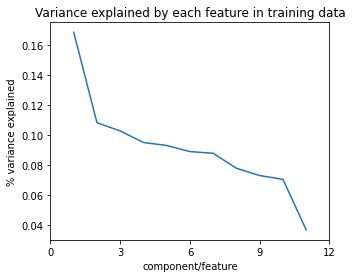

In [133]:
from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
pca.explained_variance_ratio_

plt.figure(figsize=(5,4))
plt.plot(range(1,12),pca.explained_variance_ratio_)
plt.xlim((0,12))
plt.xlabel("component/feature")
plt.xticks((0,3,6,9,12))
plt.ylabel("% variance explained")
plt.title('Variance explained by each feature in training data')

In [134]:
#LDA??

#### **Part 3.2.6: KNN** 

In [135]:
#KNN Classifer using default parameters 
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train) 
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
print('Accuracy of KNN Classifier on train data: {0:0.2f}%'.format(acc_knn))
acc_knn_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of KNN Classifier on test data: {}%'.format(round(acc_knn_test*100,2)))

classifier_acc_train['KNN'] = acc_knn
classifier_acc_test['KNN'] = acc_knn_test

Accuracy of KNN Classifier on train data: 85.71%
Accuracy of KNN Classifier on test data: 81.37%


In [136]:
eval_metrics(Y_test, Y_pred, 'KNN')

Evaluation Metrics using KNN classifier...

TN: 11191
FP: 1244
FN: 1789
TP: 2057

Recall: 0.5348413936557462
Precision: 0.6231445016661618
FP Rate: 0.10004020908725372
ROC AUC: 0.7174005922842462


#### **Part 3.2.7: SVM Classifier**   

In [137]:
#SVM Classifer using default parameters 

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
print('Accuracy of SVM Classifier on train data: {0:0.2f}%'.format(acc_linear_svc))
acc_linear_svc_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of SVM Classifier on test data: {}%'.format(round(acc_linear_svc_test*100,2)))

classifier_acc_train['SVM'] = acc_linear_svc
classifier_acc_test['SVM'] = acc_linear_svc_test

Accuracy of SVM Classifier on train data: 77.72%
Accuracy of SVM Classifier on test data: 78.21%


In [138]:
eval_metrics(Y_test, Y_pred, 'SVM')

Evaluation Metrics using SVM classifier...

TN: 12262
FP: 173
FN: 3375
TP: 471

Recall: 0.12246489859594384
Precision: 0.7313664596273292
FP Rate: 0.013912344189786891
ROC AUC: 0.5542762772030785


#### **Part 3.2.8: Stochastic Gradient Boosting Classifier**   

In [139]:
#Stochastic Gradient Boosting Classifier using default parameters 
model = GradientBoostingClassifier()
gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(X_train, Y_train)
Y_pred = gradient_boost.predict(X_test)
acc_grad_boost = round(gradient_boost.score(X_train, Y_train) * 100, 2)
print('Accuracy of SGB Classifier on train data: {0:0.2f}%'.format(acc_grad_boost))
acc_grad_boost_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of SGB Classifier on test data: {}%'.format(round(acc_grad_boost_test*100,2)))

classifier_acc_train['SGB'] = acc_grad_boost
classifier_acc_test['SGB'] = acc_grad_boost_test


Accuracy of SGB Classifier on train data: 86.16%
Accuracy of SGB Classifier on test data: 82.71%


In [140]:
eval_metrics(Y_test, Y_pred, 'SGB')

Evaluation Metrics using SGB classifier...

TN: 10761
FP: 1674
FN: 1141
TP: 2705

Recall: 0.703328133125325
Precision: 0.6177209408540763
FP Rate: 0.13462002412545235
ROC AUC: 0.7843540544999362


#### **Part 3.2.9: GaussianNB Classifier**    

In [141]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
print('Accuracy of GNB Classifier on train data: {0:0.2f}%'.format(acc_gaussian))
acc_gaussian_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of GNB Classifier on test data: {}%'.format(round(acc_gaussian_test*100,2)))

classifier_acc_train['GNB'] = acc_gaussian
classifier_acc_test['GNB'] = acc_gaussian_test


Accuracy of GNB Classifier on train data: 77.53%
Accuracy of GNB Classifier on test data: 77.79%


In [142]:
eval_metrics(Y_test, Y_pred, 'GNB')

Evaluation Metrics using GNB classifier...

TN: 10270
FP: 2165
FN: 1451
TP: 2395

Recall: 0.6227249089963599
Precision: 0.5252192982456141
FP Rate: 0.17410534780860473
ROC AUC: 0.7243097805938775


#### **Part 3.2.10: CatBoost Classifier**  

In [143]:
clf= CatBoostClassifier(verbose=False)
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
acc_catboost = round(clf.score(X_train, Y_train)*100,2)
print('Accuracy of CatBoost Classifier on train data: {0:0.2f}%'.format(acc_catboost))
acc_catboost_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of CatBoost Classifier on test data: {}%'.format(round(acc_catboost_test*100,2)))

classifier_acc_train['Cat'] = acc_catboost
classifier_acc_test['Cat'] = acc_catboost_test


Accuracy of CatBoost Classifier on train data: 88.79%
Accuracy of CatBoost Classifier on test data: 79.63%


In [144]:
eval_metrics(Y_test, Y_pred, 'Cat')

Evaluation Metrics using Cat classifier...

TN: 10166
FP: 2269
FN: 1048
TP: 2798

Recall: 0.7275091003640146
Precision: 0.5522005131241365
FP Rate: 0.18246883795737837
ROC AUC: 0.7725201312033182


#### **Part 3.2.11: CNN Classifier** 

### **Part 3.3: Classifier Results** 

**Classifier Results from default parameters**

In [145]:
classifier_acc_train

{'Bagged Decision Tree': 91.85,
 'Cat': 88.79,
 'Decision Tree': 92.33,
 'GNB': 77.53,
 'KNN': 85.71,
 'Log Regression': 77.7,
 'RF': 92.32,
 'SGB': 86.16,
 'SVM': 77.72}

In [146]:
classifier_acc_test.update((x, y*100) for x, y in classifier_acc_test.items())


In [147]:
classifier_acc_test

{'Bagged Decision Tree': 81.21122781155948,
 'Cat': 79.6265585651987,
 'Decision Tree': 76.8318899330508,
 'GNB': 77.7900620355015,
 'KNN': 81.37092316196794,
 'Log Regression': 78.20772679810823,
 'RF': 82.64234383637368,
 'SGB': 82.70990725385418,
 'SVM': 78.20772679810823}

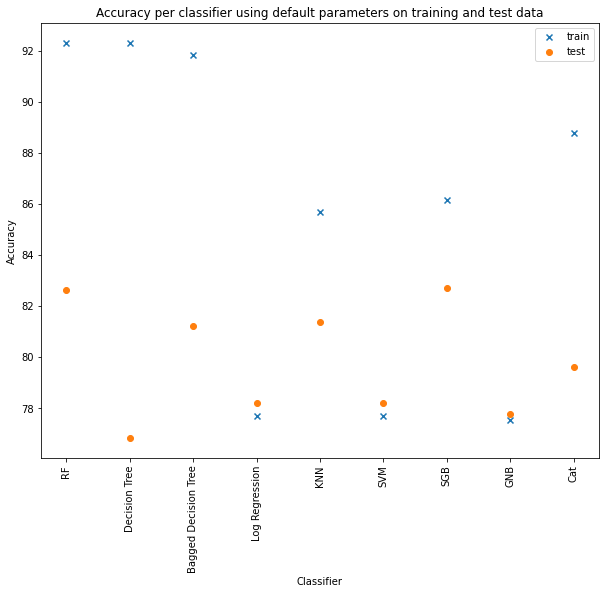

In [148]:
plt.figure(figsize=(10,8))
plt.scatter(classifier_acc_train.keys(), classifier_acc_train.values(),  marker='x', label='train')
plt.scatter(classifier_acc_test.keys(), classifier_acc_test.values(),  marker='o',label='test')
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.title('Accuracy per classifier using default parameters on training and test data')
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Classifier', fontsize=10)
plt.show()


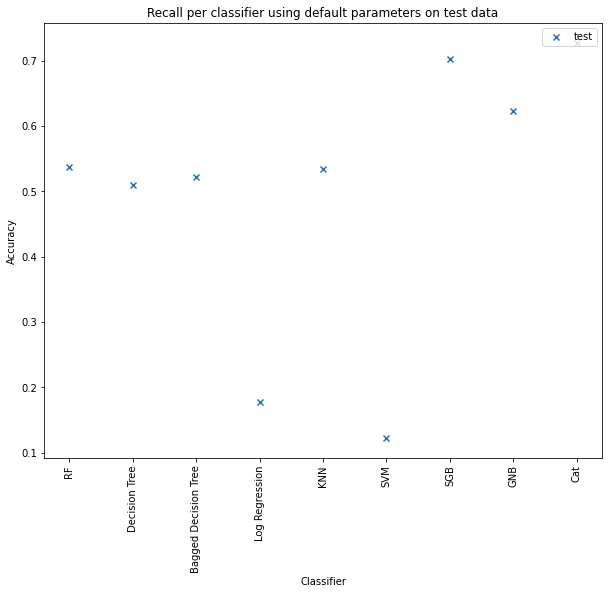

In [149]:
plt.figure(figsize=(10,8))
plt.scatter(classifier_recall.keys(), classifier_recall.values(),  marker='x', label='test')
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.title('Recall per classifier using default parameters on test data')
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Classifier', fontsize=10)
plt.show()


In [150]:
classifier_precision

{'Bagged Decision Tree': 0.6218643542892537,
 'Cat': 0.5522005131241365,
 'Decision Tree': 0.5096004151530877,
 'GNB': 0.5252192982456141,
 'KNN': 0.6231445016661618,
 'Log Regression': 0.6400375939849624,
 'RF': 0.6638817480719794,
 'SGB': 0.6177209408540763,
 'SVM': 0.7313664596273292}

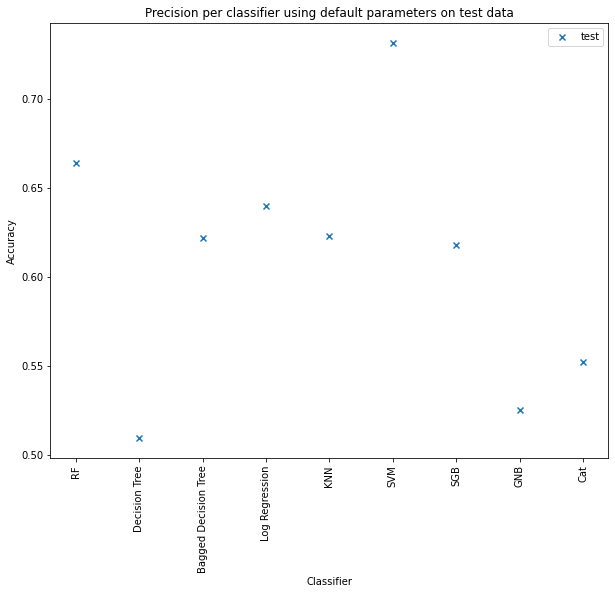

In [151]:
plt.figure(figsize=(10,8))
plt.scatter(classifier_precision.keys(), classifier_precision.values(),  marker='x', label='test')
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.title('Precision per classifier using default parameters on test data')
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Classifier', fontsize=10)
plt.show()

In [152]:
classifier_auc

{'Bagged Decision Tree': 0.7119551464808894,
 'Cat': 0.7725201312033182,
 'Decision Tree': 0.6793350382989988,
 'GNB': 0.7243097805938775,
 'KNN': 0.7174005922842462,
 'Log Regression': 0.5731334609234792,
 'RF': 0.7265320383623548,
 'SGB': 0.7843540544999362,
 'SVM': 0.5542762772030785}

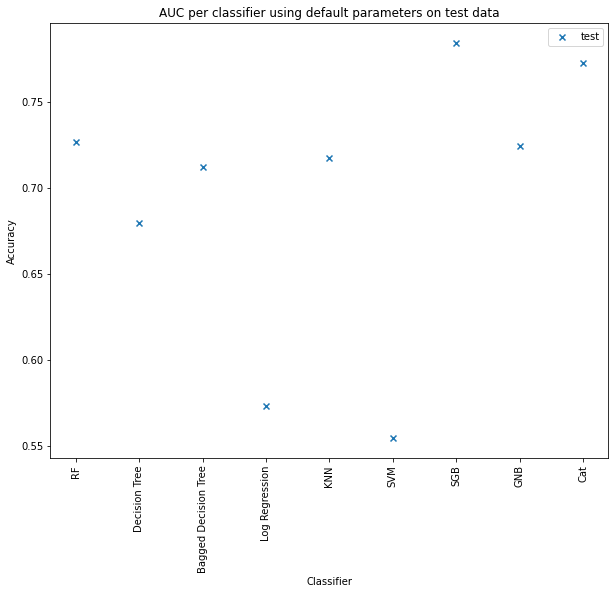

In [153]:
plt.figure(figsize=(10,8))
plt.scatter(classifier_auc.keys(), classifier_auc.values(),  marker='x', label='test')
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.title('AUC per classifier using default parameters on test data')
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Classifier', fontsize=10)
plt.show()

###**Part 3.4 - Hyperparameter Tuning** <br>

*hyperparameter tuning function skipped in this section to avoid long hyperparamter tuning process

In [154]:
classifier_hptuning_scores = {}
classifier_hptuning_params = {}
classifier_hptuning_recall = {}
classifier_hptuning_precision = {}
classifier_hptuning_auc = {}


In [155]:

def tune_classifier(classifier, model, grid, training, labels):

    print('Hyperparameter Tuning for {} classifer...'.format(classifier))
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    grid_result = grid_search.fit(training, labels)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print('\n')
    classifier_hptuning_scores[classifier] = grid_result.best_score_
    classifier_hptuning_params[classifier] = grid_result.best_params_

#for all models/classifiers call 
# tune_classifer(model, grid)

In [156]:
#tune all classifiers 

grid_classifiers = {}

#Random Forest Classifer
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
grid_rf = dict(n_estimators=n_estimators,max_features=max_features)
grid_classifiers['RF'] = grid_rf

#Decision Tree Classifier
criterion = ['gini','entropy']
max_depth = range(1,10)
min_samples_split = range(1,10)
min_samples_leaf = range(1,5)
grid_dt = dict(criterion=criterion,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
grid_classifiers['DT'] = grid_dt

#Bagged Decision Tree Classifier
n_estimators = [10, 100, 1000]
grid_bdt = dict(n_estimators=n_estimators)
grid_classifiers['BDT'] = grid_bdt


#Logisitc Regression Classifier
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid_logreg = dict(solver=solvers,penalty=penalty,C=c_values)
grid_classifiers['Log'] = grid_logreg


#KNN Classifer
n_neighbours = np.arange(1,15,2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
grid_knn = dict(n_neighbors=n_neighbours,weights=weights,metric=metric)
grid_classifiers['KNN'] = grid_knn

#SVM Classifier
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
grid_svm = dict(kernel=kernel,C=C,gamma=gamma)
grid_classifiers['SVM'] = grid_svm

#Gradient Boosting Classifier
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
grid_gb = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
grid_classifiers['GB'] = grid_gb


#GaussianNB Classifier
var_smoothing = np.logspace(0,-9, num=100)
grid_gnb = dict(var_smoothing=var_smoothing)
grid_classifiers['GNB'] = grid_gnb

#CatBoost Classifier
depth = [3,1,2,6,4,5,7,8,9,10]
iterations = [250,100,500,1000]
learning_rate = [0.03,0.001,0.01,0.1,0.2,0.3]
l2_leaf_reg = [3,1,5,10,100]
border_count = [32,5,10,20,50,100,200]
ctr_border_count = [50,5,10,20,100,200]
thread_count = 4
grid_cat = dict(depth=depth, iterations=iterations, learning_rate=learning_rate, l2_leaf_reg=l2_leaf_reg,border_count=border_count,ctr_border_count=ctr_border_count,thread_count=thread_count)
grid_classifiers['Cat'] = grid_cat

In [157]:
grid_classifiers['GB']

{'learning_rate': [0.001, 0.01, 0.1],
 'max_depth': [3, 7, 9],
 'n_estimators': [10, 100, 1000],
 'subsample': [0.5, 0.7, 1.0]}

In [158]:
grid_classifiers['RF']

{'max_features': ['sqrt', 'log2'], 'n_estimators': [10, 100, 1000]}

In [159]:

################################################################
###        Hyperparameter Tuning for all Classifiers         ###
################################################################

def hyperparameter_tuning():

  for key in grid_classifiers:
    if key == 'RF':
      model = RandomForestClassifier()
      tune_classifier(key,model,grid_classifiers[key], X_train, Y_train)
    elif key == 'DT':
      model = DecisionTreeClassifier()
      tune_classifier(key,model,grid_classifiers[key], X_train, Y_train)
    elif key == 'BDT':
      model = BaggingClassifier()
      tune_classifier(key,model,grid_classifiers[key], X_train, Y_train)
    elif key == 'Log':
      model = LogisticRegression()
      tune_classifier(key,model,grid_classifiers[key], X_train, Y_train)
    elif key == 'KNN':
      model = KNeighborsClassifier()
      tune_classifier(key,model,grid_classifiers[key], X_train, Y_train)
    elif key == 'SVM':      #SVM takes a very long time to execute 
      model = SVC()
      tune_classifier(key,model,grid_classifiers[key], X_train, Y_train)
    elif key == 'GB':
      model = GradientBoostingClassifier()
      tune_classifier(key,model,grid_classifiers[key])
    elif key == 'GNB':
      model = GaussianNB()
      tune_classifier(key,model,grid_classifiers[key])
    elif key == 'Cat':
      model = CatBoostClassifier()
      tune_classifier(key,model,grid_classifiers[key])


In [160]:
# #getting best hyperparameters for each classifier
# start_time = time.clock()
# hyperparameter_tuning()

# elapsed_time = time.clock() - start_time
# print('Total time for hyperparameter tuning: ', elapsed_time)


In [161]:
#get classificer metrics, accuracy, AUC, precision, recall, FP/FN etc

###**Part 3.5 - Selecting Classifier** <br>
After the above process of hyperparameter tuning, the choice of classifier for the bias analysis task is the **Random Forest** classifier. This algorithm gave accuracy results of ~85%. The chosen hyperparameters chosen for it are **n_estimators = 1000** and the **max_features = log2**, with all other parameters set to their default value. Although some classifiers gave a slightly increased classification accuracy such as SVM, they were not chosen due to the simplicity of RF's and the enhanced computational complexity and training time of other classifiers.

In [162]:
# model = RandomForestClassifier()
# tune_classifier('RF',model,grid_classifiers['RF'], X_train, Y_train)

In [163]:

#training chosen classifier with desired parameters
random_forest = RandomForestClassifier(n_estimators=1000,max_features='sqrt')
random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print('Accuracy of Random Forest Classifier on train data: {}%'.format(acc_random_forest))
acc_random_forest_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of Random Forest Classifier on test data: {}%'.format(round(acc_random_forest_test*100,2)))



Accuracy of Random Forest Classifier on train data: 92.33%
Accuracy of Random Forest Classifier on test data: 82.73%


In [164]:
eval_metrics(Y_test, Y_pred, 'RF')

Evaluation Metrics using RF classifier...

TN: 11397
FP: 1038
FN: 1773
TP: 2073

Recall: 0.5390015600624025
Precision: 0.6663452266152362
FP Rate: 0.08347406513872135
ROC AUC: 0.7277637474618406


Text(0.5, 1.0, 'Feature Importance for each attribute using optimised classifier')

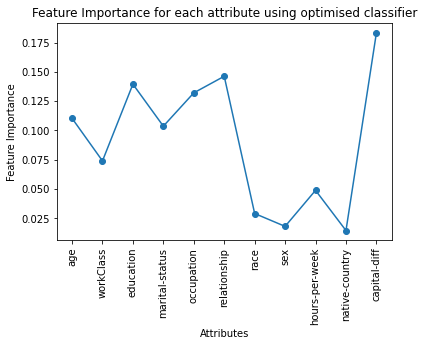

In [165]:
plt.plot(random_forest.feature_importances_,  marker='o')
plt.xticks(np.arange(len(list(X_train.columns))), list(X_train.columns), rotation=90)
plt.xlabel('Attributes')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for each attribute using optimised classifier')      #protecsted attributes still here???? 

## **Part 4: Identifying and evaluating bias**
After selecting a classifcation algorithm, as was achieved in the previous section, the next step is to identify and evaluate any bias that may be present in some of the protected attributes of the dataset, including: martial-status, relationship, race, sex and native-country. The chosen attributes for deeper analysis were relationship and race.

###**Part 4.1: Quantifying fairness and bias** 

In [187]:
#getting the index of each misclassification in prediction
def incorrect_classification(Y_test, Y_pred):

    incorrect_index = []

    for i in range(0,len(Y_pred)):
      if Y_pred[i] != Y_test[i]:
        incorrect_index.append(i)
    
    return incorrect_index

#getting the index of each positive classification in prediction
def positive_classification(Y_test, Y_pred):

    correct_index = []

    for i in range(0,len(Y_pred)):
      if Y_pred[i] == 1:
        correct_index.append(i)
        
    return correct_index

#getting the index of each negative classification in prediction
def negative_classification(Y_test, Y_pred):

    correct_index = []

    for i in range(0,len(Y_pred)):
      if Y_pred[i] == 0:
        correct_index.append(i)
        
    return correct_index

#getting the index of each correct classification in prediction
def correct_classification(Y_test, Y_pred):

    correct_index = []

    for i in range(0,len(Y_pred)):
      if Y_pred[i] == Y_test[i]:
        correct_index.append(i)
        
    return correct_index

#getting demographic parity in prediction for specified attribute
#demographic parity outlines that the positive rate should be the same across all demographic groups within the attribute 
#e.g the classifcation of >50k should have the same rate for white and black folks for race attribute 
def demographic_parity(Y_test, Y_pred, attribute):

    # correct_class = correct_classification(Y_test, Y_pred)
    correct_class = positive_classification(Y_test, Y_pred)
    class_labels = test_adult[attribute].unique()

    demo_parity = dict.fromkeys(class_labels, 0)
    total_correct = 0

    for i in correct_class:
      for j in class_labels:
        if (test_adult[attribute][i]) == j:
          demo_parity[j] = demo_parity[j] + 1
          total_correct += 1

    for key, val in demo_parity.items():
      total_for_label = test_adult[attribute].value_counts()[key]
      demo_par = demo_parity[key] / total_for_label
      demo_parity[key] = demo_par

    return demo_parity 

    # P(Ŷ | A = 0) = P(Ŷ | A = 1) = P(Ŷ | A = 2)...

    # pass

#getting equality of opportunity metric - TNR and or TPR should be the same for all classes in a group
def equality_of_opportunity(Y_test, Y_pred, attribute):

    class_labels = test_adult[attribute].unique()

    equal_opp = dict.fromkeys(class_labels, 0)

    for i in range(0, len(Y_pred)):
      if Y_pred[i] == 1:
        if test_adult['income'][i] == 1:
          attribute_class = test_adult[attribute][i]
          equal_opp[attribute_class] = equal_opp[attribute_class] + 1

    for key, val in equal_opp.items():
      total_for_label = test_adult[attribute].value_counts()[key]
      eq_op = equal_opp[key] / total_for_label
      equal_opp[key] = eq_op

    return equal_opp
      # True Positive Rate (A=0) = True Positive Rate (A=1)
  
#work out fp rate and combine with equal_of_opp
def equalised_odds(Y_test, Y_pred, attribute):

    demo_par = demographic_parity(Y_test, Y_pred, attribute)
    demo_par_vals = []
    for k, v in demo_par.items():
      demo_par_vals.append(demo_par[k])

    equal_op = equality_of_opportunity(Y_test, Y_pred, attribute)
    equal_op_vals = []
    for k, v in equal_op.items():
      equal_op_vals.append(equal_op[k])
    
    fp_rates = []

    for val in range(0, len(demo_par_vals)):
      fp_rates.append(demo_par_vals[val] - equal_op_vals[val])
    
        
    class_labels = test_adult[attribute].unique()

    equal_odds = dict.fromkeys(class_labels, 0)
    
    # fp_rate = demographic_parity() - equality_of_opportunity()
    
    # for i in range(0, len(Y_pred)):
    #   if Y_pred[i] == 1:
    #     if test_adult['income'][i] == 0:
    #       att = test_adult[attribute][i]
    #       equal_odds[att] = equal_odds[att] + 1

    #get true pos
    equal_of_opp = equality_of_opportunity(Y_test, Y_pred, attribute)

    i = 0 
    for k,v in equal_of_opp.items():
      equal_odds[k] = equal_of_opp[k] + fp_rates[i]
      i+=1

    for key, val in equal_odds.items():
      total_for_label = test_adult[attribute].value_counts()[key]
      equalised_odds = equal_odds[key] / total_for_label
      equal_odds[key] = equalised_odds

    return equal_odds   #returning TP rate & FP Rate 

def fairness_metrics(Y_test, Y_pred, attribute, verbose=False):

    demo_parity = demographic_parity(Y_test, Y_pred, attribute)
    eq_of_opp = equality_of_opportunity(Y_test, Y_pred, attribute)
    eq_odds = equalised_odds(Y_test, Y_pred, attribute)

    if verbose:
      print('Demographic parity for {} is {} '.format(attribute, demo_parity))
      print('Equality of opportunity for {} is {} '.format(attribute, eq_of_opp))
      print('Equalised Odds for {} is {} \n'.format(attribute, eq_odds))

    return demo_parity, eq_of_opp, eq_odds

#   True Positive Rate (A=0) = True Positive Rate (A=1) , and
# False Positive Rate (A=0) = False Positive Rate (A=1)

In [188]:

def pie_plot(attribute, Y_test, Y_pred, plot_type='correct', correct_class=True):

    class_labels = test_adult[attribute].unique()

    if plot_type == 'correct':
       index = correct_classification(Y_test, Y_pred)
    elif plot_type == 'incorrect':
       index = incorrect_classification(Y_test, Y_pred)
    elif plot_type == 'positive':
       index = positive_classification(Y_test, Y_pred)
    elif plot_type == 'negative':
       index = negative_classification(Y_test, Y_pred)

    classification_ratio = dict.fromkeys(class_labels, 0)

    for i in index:
      for j in class_labels:
        if (test_adult[attribute][i]) == j:
          classification_ratio[j] = classification_ratio[j] + 1

    # Pie chart
    labels = list(classification_ratio.keys())
    values = list(classification_ratio.values())
    #colors
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#9933FF','#FCFF33', '#E25626','#E4ABCA','#B9B9B9']
    #explsion
    explode = [0.05] * len(labels)
    # (0.05,0.05,0.05,0.05,0.05)

    plt.figure(figsize=(12,8))
    plt.pie(values, colors = colors,  autopct='%1.1f%%', startangle=90, explode=explode,pctdistance=0.85, rotatelabels=True, shadow=True)
    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    # ax1.axis('equal')  
    plt.tight_layout()
    plt.legend(labels)
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
  
    if correct_class:
      plt.title('Pie plot of correct classification for {} attribute'.format(attribute))
    else:
      plt.title('Pie plot of incorrect classification for {} attribute'.format(attribute))

    plt.show()

def plotting_metrics(metric='demographic_parity'):

    # sensitive_attrs = ['marital-status', 'relationship','sex','race','native-country']
    sensitive_attrs = ['relationship','race']

    colors = ['red','green','blue','orange','purple']

    initial_subplot = 1
    initial_color = 0
    plt.figure(figsize=(16,8))

    for attr in sensitive_attrs:

        demo_parity, eq_of_opp, eq_odds = fairness_metrics(Y_test, Y_pred, attr)
        labels = test_adult[attr].unique()

        if metric =='demographic_parity':
          vals = list(demo_parity.values()) 
        elif metric =='equality_of_opportunity':
          vals = list(eq_of_opp.values()) 
        elif metric =='equalised_odds':
           vals = list(eq_odds.values()) 
        else: 
          print('Invalid metric passed to function')

        plt.subplot(2, 3, initial_subplot)
        plt.bar(labels,vals, color=colors[initial_color])
        plt.xticks(rotation=90)

        initial_subplot+=1
        initial_color+=1

    plt.tight_layout(pad=0.6)
    plt.show()

### **Part 4.2 Excluding all protected attributes from classification model** 

In [189]:
X_train_bias_all = X_train.copy()
X_test_bias_all = X_test.copy()

In [190]:
X_train_bias_all = X_train_bias_all.drop(['marital-status', 'relationship','race','sex','native-country'],axis =1)
X_test_bias_all = X_test_bias_all.drop(['marital-status', 'relationship','race','sex','native-country'], axis = 1)

In [191]:
X_train_bias_all.head()

,age,workClass,education,occupation,hours-per-week,capital-diff
0,-0.234004,2.624298,-1.098810,-1.545256,0.727859,1.157523
1,0.428725,1.721100,-1.098810,-0.790092,-0.486084,-0.126989
2,-0.234004,-0.085296,-0.393115,-0.286649,0.727859,-0.126989
3,1.091454,-0.085296,1.018273,-0.286649,0.727859,-0.126989
4,-0.896732,-0.085296,-1.098810,0.720237,0.727859,-0.126989


In [192]:
#hyperparameter tuning with all protected attributes removed
# model = RandomForestClassifier()
# tune_classifier('RF',model,grid_classifiers['RF'], X_train_bias_all, Y_train)   #********

In [193]:
#training classifier using optimal parameters 
random_forest = RandomForestClassifier(n_estimators=1000, max_features='log2')  #check using optimal params
random_forest.fit(X_train_bias_all, Y_train)

Y_pred = random_forest.predict(X_test_bias_all)
random_forest.score(X_train_bias_all, Y_train)

acc_random_forest = round(random_forest.score(X_train_bias_all, Y_train) * 100, 2)
print('Accuracy of Random Forest Classifier on train data: {}%'.format(acc_random_forest))
acc_random_forest_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of Random Forest Classifier on test data: {}%'.format(round(acc_random_forest_test*100,2)))


Accuracy of Random Forest Classifier on train data: 87.35%
Accuracy of Random Forest Classifier on test data: 78.85%


In [194]:
eval_metrics(Y_test, Y_pred, 'RF')

Evaluation Metrics using RF classifier...

TN: 10926
FP: 1509
FN: 1935
TP: 1911

Recall: 0.4968798751950078
Precision: 0.5587719298245614
FP Rate: 0.12135102533172497
ROC AUC: 0.6877644249316415


####**Part 4.2.1: Plots and visualisations**

Text(0.5, 1.0, 'Feature Importance for each attribute')

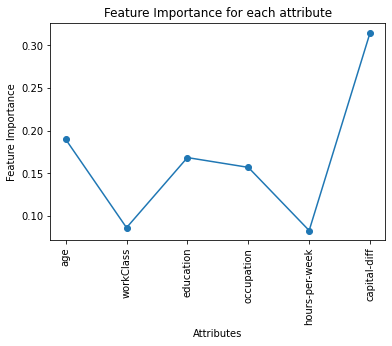

In [195]:
plt.plot(random_forest.feature_importances_,  marker='o')
plt.xticks(np.arange(len(list(X_train_bias_all.columns))), list(X_train_bias_all.columns), rotation=90)
plt.xlabel('Attributes')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for each attribute')     

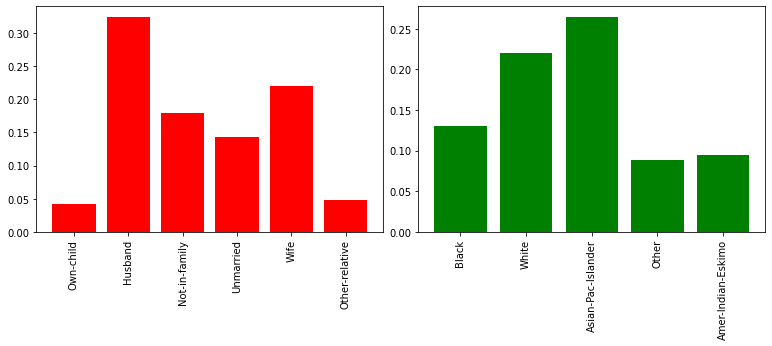

In [196]:
plotting_metrics(metric='demographic_parity')

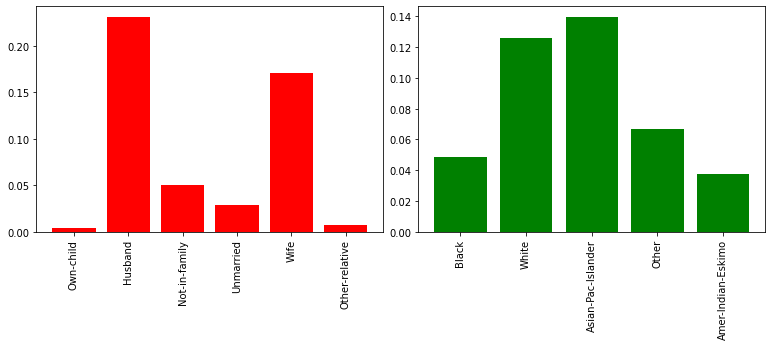

In [197]:
plotting_metrics(metric='equality_of_opportunity')

In [198]:
# plotting_metrics(metric='equalised_odds')

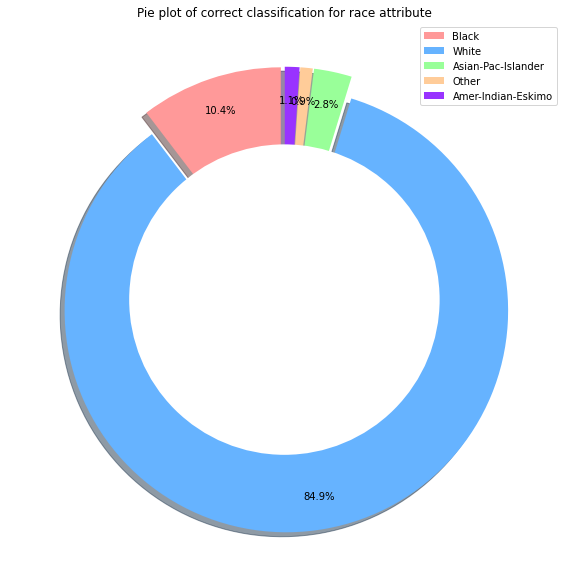

In [199]:
pie_plot('race', Y_test, Y_pred)

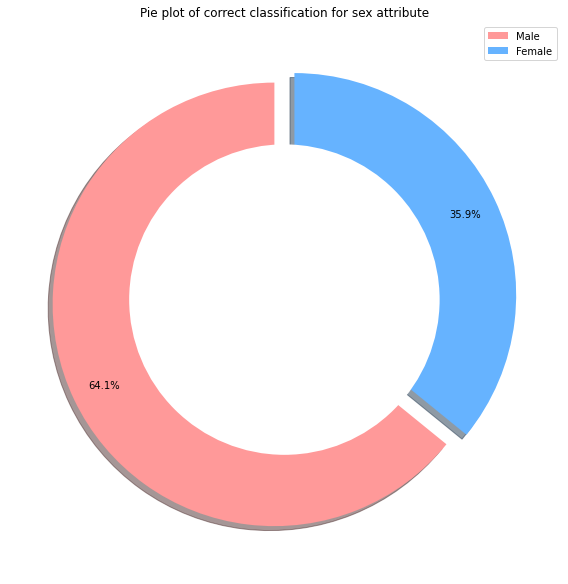

In [200]:
pie_plot('sex', Y_test, Y_pred)

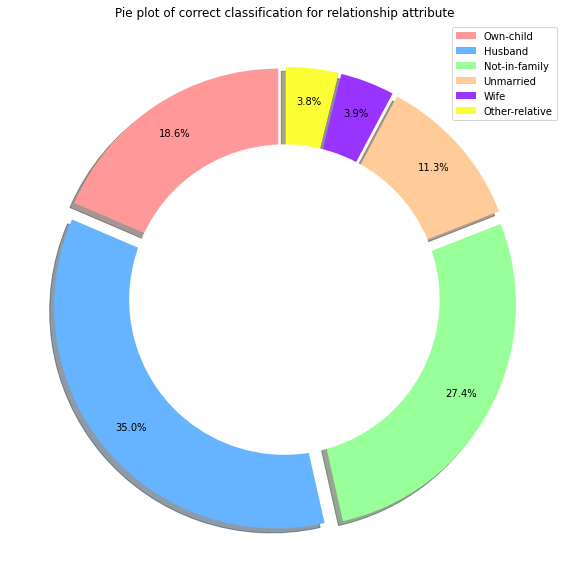

In [201]:
pie_plot('relationship', Y_test, Y_pred)

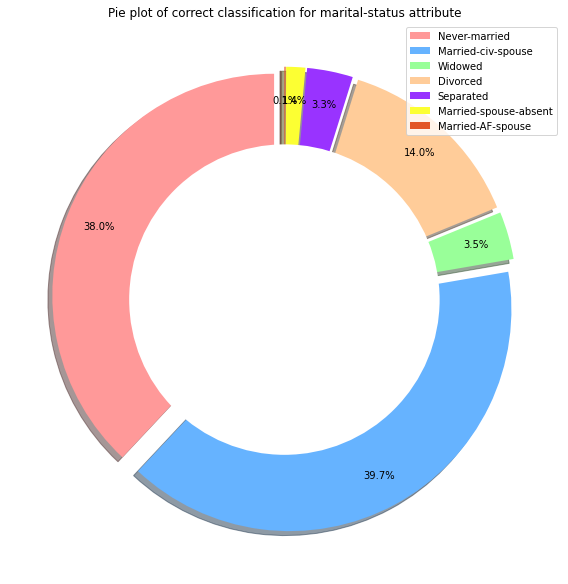

In [202]:
pie_plot('marital-status', Y_test, Y_pred)

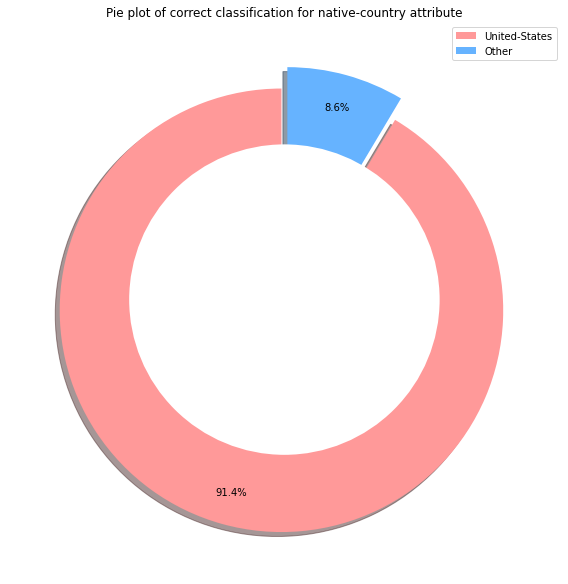

In [203]:
pie_plot('native-country', Y_test, Y_pred)

In [204]:
# demographic_parity val/total number of +ves for attribute 
# len(test_adult[(test_adult['race']=='Black') & (test_adult['income']==1)])

# Demographic parity for race is {'Black': 1345, (1345 classifiactions were correct from classifier) - 216 were incorrect   

# 1345/1561 - Parity metric for blacks
# 'White': 10925,
# 10925/13946 

###**Part 4.3: Excluding relationship and race attributes from classification model** 

In [205]:
X_train_bias = X_train.copy()
X_test_bias = X_test.copy()

In [206]:
X_train_bias = X_train_bias.drop(['relationship','race'],axis =1)
X_test_bias = X_test_bias.drop(['relationship','race'], axis = 1)

In [207]:
#hyperparameter tuning with two protected attributes removed
# model = RandomForestClassifier()
# tune_classifier('RF',model,grid_classifiers['RF'], X_train_bias, Y_train) #***

In [208]:
#training with optimal parameters 
random_forest = RandomForestClassifier(n_estimators=1000, max_features='log2')
random_forest.fit(X_train_bias, Y_train)

Y_pred = random_forest.predict(X_test_bias)
random_forest.score(X_train_bias, Y_train)

acc_random_forest = round(random_forest.score(X_train_bias, Y_train) * 100, 2)
print('Accuracy of Random Forest Classifier on train data: {}%'.format(acc_random_forest))
acc_random_forest_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of Random Forest Classifier on test data: {}%'.format(round(acc_random_forest_test*100,2)))


Accuracy of Random Forest Classifier on train data: 91.47%
Accuracy of Random Forest Classifier on test data: 82.5%


In [209]:
eval_metrics(Y_test, Y_pred, 'RF')

Evaluation Metrics using RF classifier...

TN: 11329
FP: 1106
FN: 1743
TP: 2103

Recall: 0.546801872074883
Precision: 0.6553443440324088
FP Rate: 0.08894250100522719
ROC AUC: 0.7289296855348278


In [210]:
demo_parity, eq_of_opp, eq_odds = fairness_metrics(Y_test, Y_pred, 'race')

In [211]:
demo_parity

{'Amer-Indian-Eskimo': 0.09433962264150944,
 'Asian-Pac-Islander': 0.2625,
 'Black': 0.09865470852017937,
 'Other': 0.07407407407407407,
 'White': 0.20823175103972466}

In [212]:
print('Average demographic Pariy for race attribute is {}'.format((sum(list(demo_parity.values()))/len(list(demo_parity.values())))))

Average demographic Pariy for race attribute is 0.1475600312550975


In [213]:
eq_of_opp

{'Amer-Indian-Eskimo': 0.05660377358490566,
 'Asian-Pac-Islander': 0.16041666666666668,
 'Black': 0.053811659192825115,
 'Other': 0.05185185185185185,
 'White': 0.13810411587551985}

In [214]:
print('Average Equality of opportunity for race attribute is {}'.format((sum(list(eq_of_opp.values()))/len(list(eq_of_opp.values())))))

Average Equality of opportunity for race attribute is 0.09215761343435383


In [215]:
demo_parity, eq_of_opp, eq_odds = fairness_metrics(Y_test, Y_pred, 'relationship')

In [216]:
demo_parity

{'Husband': 0.36915529664264907,
 'Not-in-family': 0.08087891538101917,
 'Other-relative': 0.04380952380952381,
 'Own-child': 0.01591723040191007,
 'Unmarried': 0.052412150089338895,
 'Wife': 0.3984272608125819}

In [217]:
#calculate average DP over all classes in attribute

In [218]:
print('Average demographic Pariy for relationship attribute is {}'.format((sum(list(demo_parity.values()))/len(list(demo_parity.values())))))

Average demographic Pariy for relationship attribute is 0.16010006285617048


In [219]:
eq_of_opp

{'Husband': 0.26214931779855893,
 'Not-in-family': 0.032491818606825616,
 'Other-relative': 0.007619047619047619,
 'Own-child': 0.00477516912057302,
 'Unmarried': 0.014889815366289458,
 'Wife': 0.27916120576671033}

In [220]:
print('Average Equality of opportunity for relationship attribute is {}'.format((sum(list(eq_of_opp.values()))/len(list(eq_of_opp.values())))))

Average Equality of opportunity for relationship attribute is 0.10018106237966751


**Evaluating metrics with different RF Hyperparameters**



In [221]:
#training with optimal parameters 
random_forest = RandomForestClassifier(n_estimators=250, max_features='log2')
random_forest.fit(X_train_bias, Y_train)

Y_pred = random_forest.predict(X_test_bias)
random_forest.score(X_train_bias, Y_train)

acc_random_forest = round(random_forest.score(X_train_bias, Y_train) * 100, 2)
print('Accuracy of Random Forest Classifier on train data: {}%'.format(acc_random_forest))
acc_random_forest_test = accuracy_score(Y_test, Y_pred)
print('Accuracy of Random Forest Classifier on test data: {}%'.format(round(acc_random_forest_test*100,2)))


Accuracy of Random Forest Classifier on train data: 91.47%
Accuracy of Random Forest Classifier on test data: 82.35%


In [222]:
eval_metrics(Y_test, Y_pred, 'RF')

Evaluation Metrics using RF classifier...

TN: 11315
FP: 1120
FN: 1753
TP: 2093

Recall: 0.5442017680707228
Precision: 0.6514161220043573
FP Rate: 0.09006835544833132
ROC AUC: 0.7270667063111956


In [223]:
demo_parity, eq_of_opp, eq_odds = fairness_metrics(Y_test, Y_pred, 'race')

In [224]:
demo_parity

{'Amer-Indian-Eskimo': 0.10062893081761007,
 'Asian-Pac-Islander': 0.25625,
 'Black': 0.09993593850096093,
 'Other': 0.07407407407407407,
 'White': 0.20851857163344328}

In [225]:
print('Average demographic Pariy for race attribute is {}'.format((sum(list(demo_parity.values()))/len(list(demo_parity.values())))))

Average demographic Pariy for race attribute is 0.14788150300521766


In [226]:
eq_of_opp

{'Amer-Indian-Eskimo': 0.050314465408805034,
 'Asian-Pac-Islander': 0.16041666666666668,
 'Black': 0.05573350416399744,
 'Other': 0.05185185185185185,
 'White': 0.13724365409436398}

In [227]:
print('Average Equality of opportunity for race attribute is {}'.format((sum(list(eq_of_opp.values()))/len(list(eq_of_opp.values())))))

Average Equality of opportunity for race attribute is 0.091112028437137


In [228]:
demo_parity, eq_of_opp, eq_odds = fairness_metrics(Y_test, Y_pred, 'relationship')

In [229]:
demo_parity

{'Husband': 0.36746895600183965,
 'Not-in-family': 0.08087891538101917,
 'Other-relative': 0.05142857142857143,
 'Own-child': 0.017508953442101075,
 'Unmarried': 0.051816557474687316,
 'Wife': 0.4089121887287025}

In [230]:
#calculate average DP over all classes in attribute

In [231]:
print('Average demographic Pariy for relationship attribute is {}'.format((sum(list(demo_parity.values()))/len(list(demo_parity.values())))))

Average demographic Pariy for relationship attribute is 0.16300235707615351


In [232]:
eq_of_opp

{'Husband': 0.26076958454698757,
 'Not-in-family': 0.03155680224403927,
 'Other-relative': 0.007619047619047619,
 'Own-child': 0.004377238360525269,
 'Unmarried': 0.015485407980941036,
 'Wife': 0.28309305373525556}

In [233]:
print('Average Equality of opportunity for relationship attribute is {}'.format((sum(list(eq_of_opp.values()))/len(list(eq_of_opp.values())))))

Average Equality of opportunity for relationship attribute is 0.10048352241446606


####**Part 4.3.1: Plots and visualisations**

Text(0.5, 1.0, 'Feature Importance for each attribute')

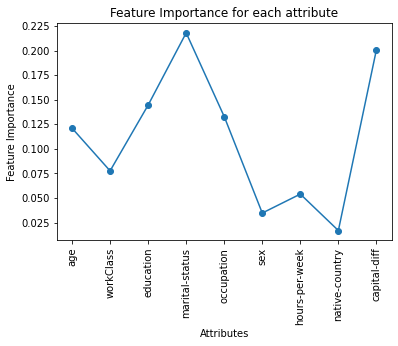

In [234]:
plt.plot(random_forest.feature_importances_,  marker='o')
plt.xticks(np.arange(len(list(X_train_bias.columns))), list(X_train_bias.columns), rotation=90)
plt.xlabel('Attributes')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for each attribute')      #protecsted attributes still here???? 

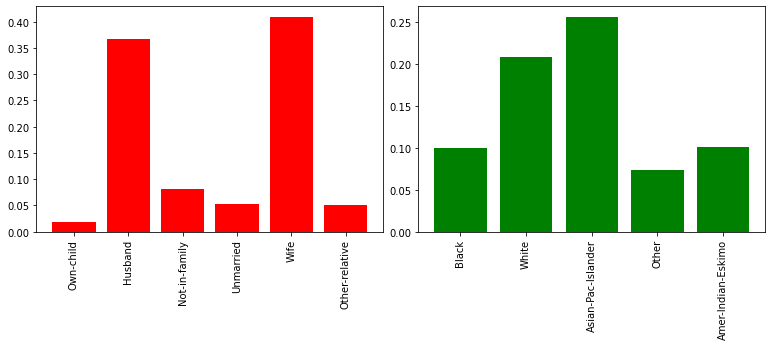

In [235]:
plotting_metrics(metric='demographic_parity')

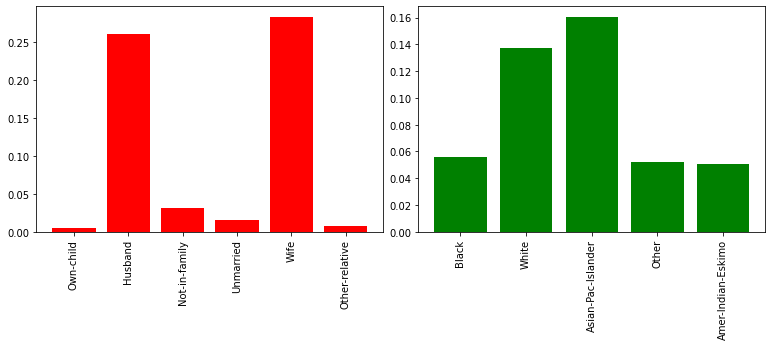

In [236]:
plotting_metrics(metric='equality_of_opportunity')

In [237]:
# plotting_metrics(metric='equalised_odds')

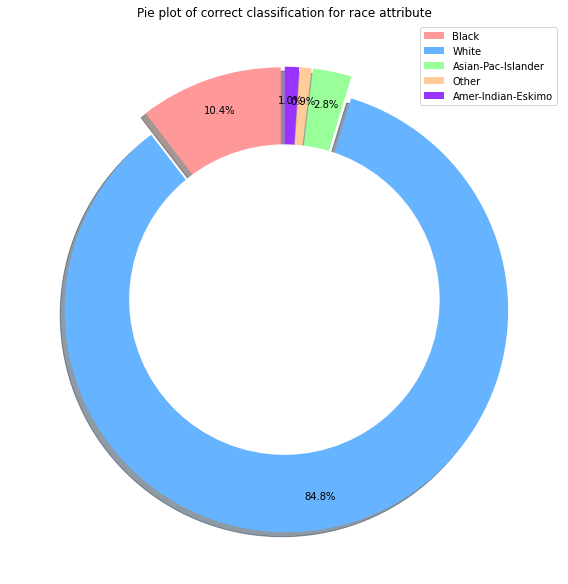

In [238]:
pie_plot('race', Y_test, Y_pred)

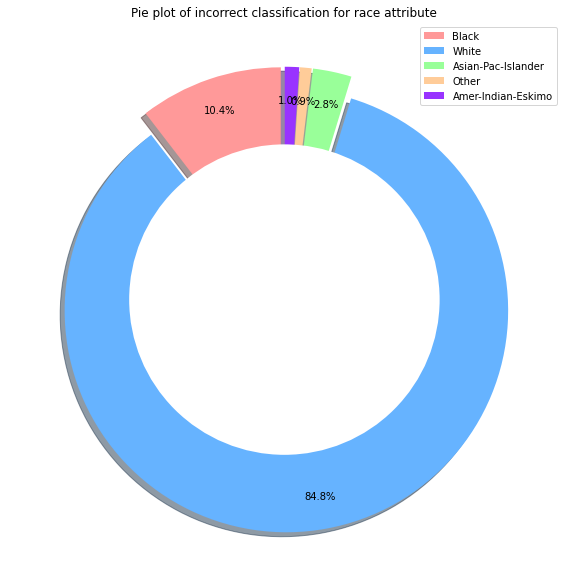

In [239]:
pie_plot('race', Y_test, Y_pred, correct_class=False)

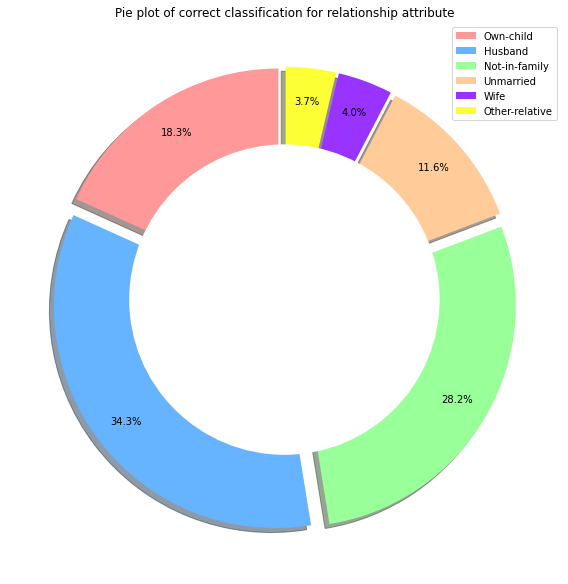

In [240]:
pie_plot('relationship', Y_test, Y_pred)

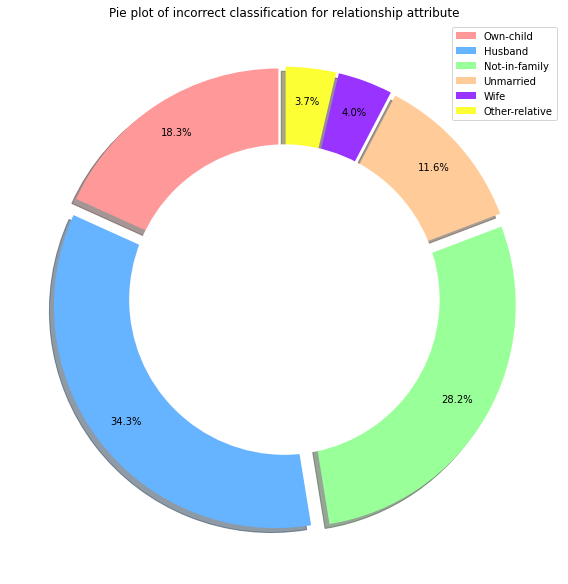

In [241]:
pie_plot('relationship', Y_test, Y_pred, correct_class=False)

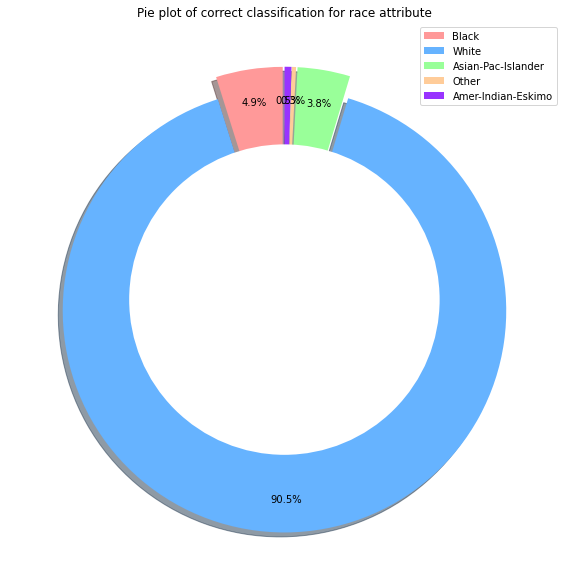

In [242]:
pie_plot('race', Y_test, Y_pred, plot_type='positive')

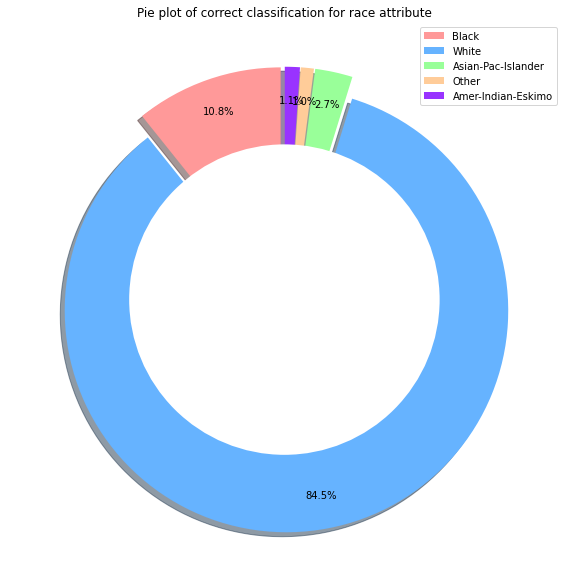

In [243]:
pie_plot('race', Y_test, Y_pred, plot_type='negative')

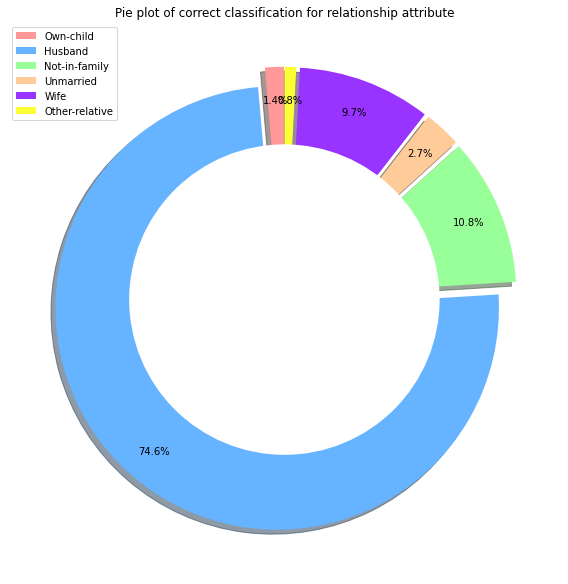

In [244]:
pie_plot('relationship', Y_test, Y_pred, plot_type='positive')

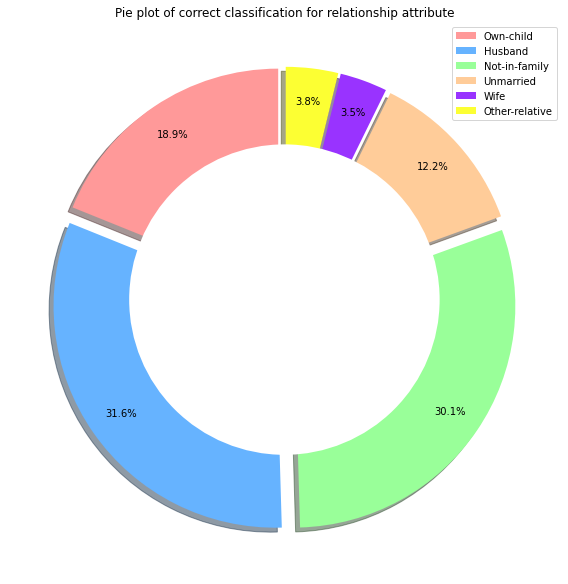

In [245]:
pie_plot('relationship', Y_test, Y_pred, plot_type='negative')

## **Part 5: Conclusion**

It is clear from the results obtained of the census-income dataset that there exists bias and possible unfairness that can be attributed to some of the sensitive attributes. It was discovered that completely removing these sensitive attributes gave a slight decrease in classification accuracy to around ~79% whilist just removing the chosen race and relationship attributes gave a marginally better accracy of ~82%. Addiotnally, looking into the results, alongside the earlier exploratory analysis section, one can conclude that much of the existing bias and or effect sensitive attributes have on final classification, can be put down to the makeup of the dataset. The dataset is unbalanced in many ways, in terms of race, sex, relationship, marital-status and native-country, with some classes and invididuals being largely underrepresented in some attributes. Ultimatly this skew in the makeup of some attributes leads to possible individual and group fairness issues, as was highlighted in Part 4. Further investigation found that that ....

## **References**

[1] - Census Income Dataset. UC Irvine Machine Learning Repository. Available from: https://archive.ics.uci.edu/ml/datasets/census+income

[2] - Ron Kohavi. 1996. Scaling up the accuracy of Naive-Bayes classifiers: a decision-tree hybrid. In Proceedings of the Second International Conference on Knowledge Discovery and Data Mining (KDD'96). AAAI Press, 202–207.

[3] - Tune Hyperparameters for Classification Machine Learning Algorithms. Machine Learning Mastery. https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

[4] - EDA + Logistic Regression + PCA on adult dataset. Kaggle. https://www.kaggle.com/prashant111/eda-logistic-regression-pca

[5] - Prediction of income with 98% accuracy on adult dataset. Kaggle. https://www.kaggle.com/jilkothari/prediction-of-income-with-98-accuracy


